# Process the images and build masks

In [50]:
#importations

import os
import SimpleITK as sitk
import numpy as np
import radiomics

from skimage import io as skio
from skimage import img_as_ubyte
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

from radiomics import featureextractor, getFeatureClasses
from radiomics import glcm

import cv2


In [51]:
#functions definition

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def mse(y_true,y_pred):
   n = len(y_true)
   mse = np.linalg.norm(y_true - y_pred)
   return mse


def flou(image, kernel_size=3):
    """
    Apply a custom random blur to an image.

    :param image: The input image (NumPy array).
    :param kernel_size: The size of the custom blur kernel (odd number).
    :return: The blurred image.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    kernel = np.random.rand(kernel_size, kernel_size)  # Random coefficients in the kernel
    kernel /= kernel.sum()  # Normalize the kernel to ensure the result is not too bright

    blurred_image = cv2.filter2D(image, -1, kernel)
    return blurred_image

def Bias_normalized_Sq(vect):
    return np.mean(np.square(vect))

def VAR_normalized(vect):
    BiasSq = Bias_normalized_Sq(vect)
    MSE = mse(vect)
    return  MSE - BiasSq
    

In [52]:
#mask functions:

def crop(im):
  n,p = im.shape
  L = min(n,p)
  return im[int((n-L)/2):int((n+L)/2), int((p-L)/2):int((p+L)/2)]


def makeMask(im,R):
  n,p = im.shape
  mask = np.zeros((n,p))

  O = np.array([int(n/2), int(p/2)])
  #R = 90    #réglé emiriquement

  for i in range(n):
    for j in range(p):
      if ( (np.linalg.norm(np.array([i,j]) - O) < R)):
        mask[i][j] = 1
  return mask


In [53]:
#images importation

im1 = crop(  img_as_ubyte( skio.imread('images/textures/cell.jpg', as_gray = True )    ))
im2 = crop( img_as_ubyte( skio.imread('images/textures/green.jpg', as_gray = True)   ))
im3 = crop( img_as_ubyte( skio.imread('images/textures/red.jpg', as_gray = True)      ))
im4 = crop(img_as_ubyte( skio.imread('images/textures/brain.jpg', as_gray = True)    ))

In [54]:
#masks initialisation

mask1 = makeMask(im1,90)
mask3 = makeMask(im3,420)
mask2 = makeMask(im2,680)


In [55]:
mask4 = np.zeros(im4.shape)
O = (300,400)

mask4[ (O[0]-70):(O[0]+70), (O[1]-70) : (O[1]+70)] = 1

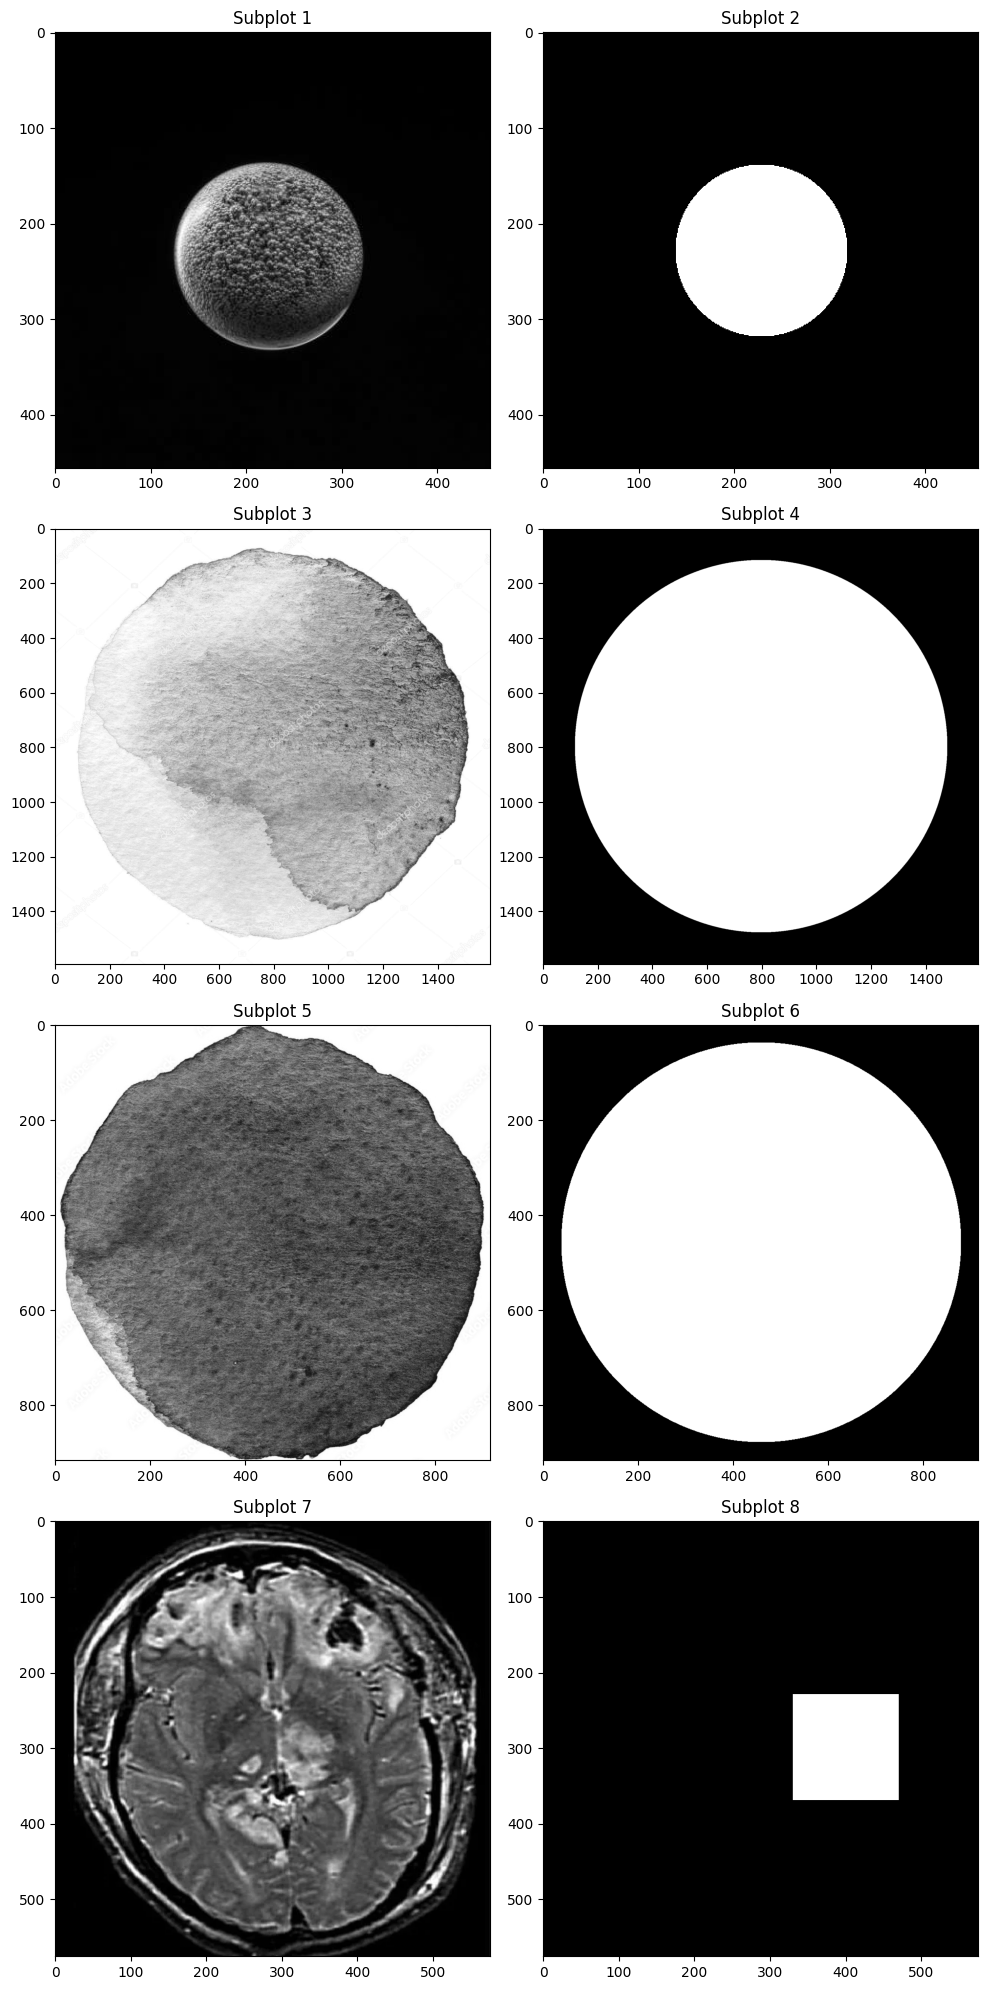

In [56]:
fig, axs = plt.subplots(4, 2,figsize=(10, 20))

# Now, you can plot your data on each subplot
axs[0, 0].imshow(im1, cmap = 'gray')
axs[0, 0].set_title('Subplot 1')
axs[0, 1].imshow(mask1, cmap = 'gray')
axs[0, 1].set_title('Subplot 2')
axs[1, 0].imshow(im2, cmap = 'gray')
axs[1, 0].set_title('Subplot 3')
axs[1, 1].imshow(mask2, cmap = 'gray')
axs[1, 1].set_title('Subplot 4')
axs[2, 0].imshow(im3, cmap = 'gray')
axs[2, 0].set_title('Subplot 5')
axs[2, 1].imshow(mask3, cmap = 'gray')
axs[2, 1].set_title('Subplot 6')
axs[3, 0].imshow(im4, cmap = 'gray')
axs[3, 0].set_title('Subplot 7')
axs[3, 1].imshow(mask4, cmap = 'gray')
axs[3, 1].set_title('Subplot 8')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Deploy the Feature Extractor (GLCM feature)

In [57]:
# Transform image and mask to the supported format
im1_ITK, mask1_ITK  = sitk.GetImageFromArray(im1), sitk.GetImageFromArray(mask1)
im2_ITK, mask2_ITK  = sitk.GetImageFromArray(im2), sitk.GetImageFromArray(mask2)
im3_ITK, mask3_ITK  = sitk.GetImageFromArray(im3), sitk.GetImageFromArray(mask3)
im4_ITK, mask4_ITK  = sitk.GetImageFromArray(im4), sitk.GetImageFromArray(mask4)
#end

In [58]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [59]:
features = np.array(list(result.values()))
args = list(result.keys())

In [60]:
im_noised_list = [noise(im1, 5).astype(np.int32)        for i in range(50)]
im_noised_list +=[noise(im1,br = 20).astype(np.int32)   for i in range(50)]
im_noised_list +=[noise(im1,br = 50).astype(np.int32)   for i in range(50)]


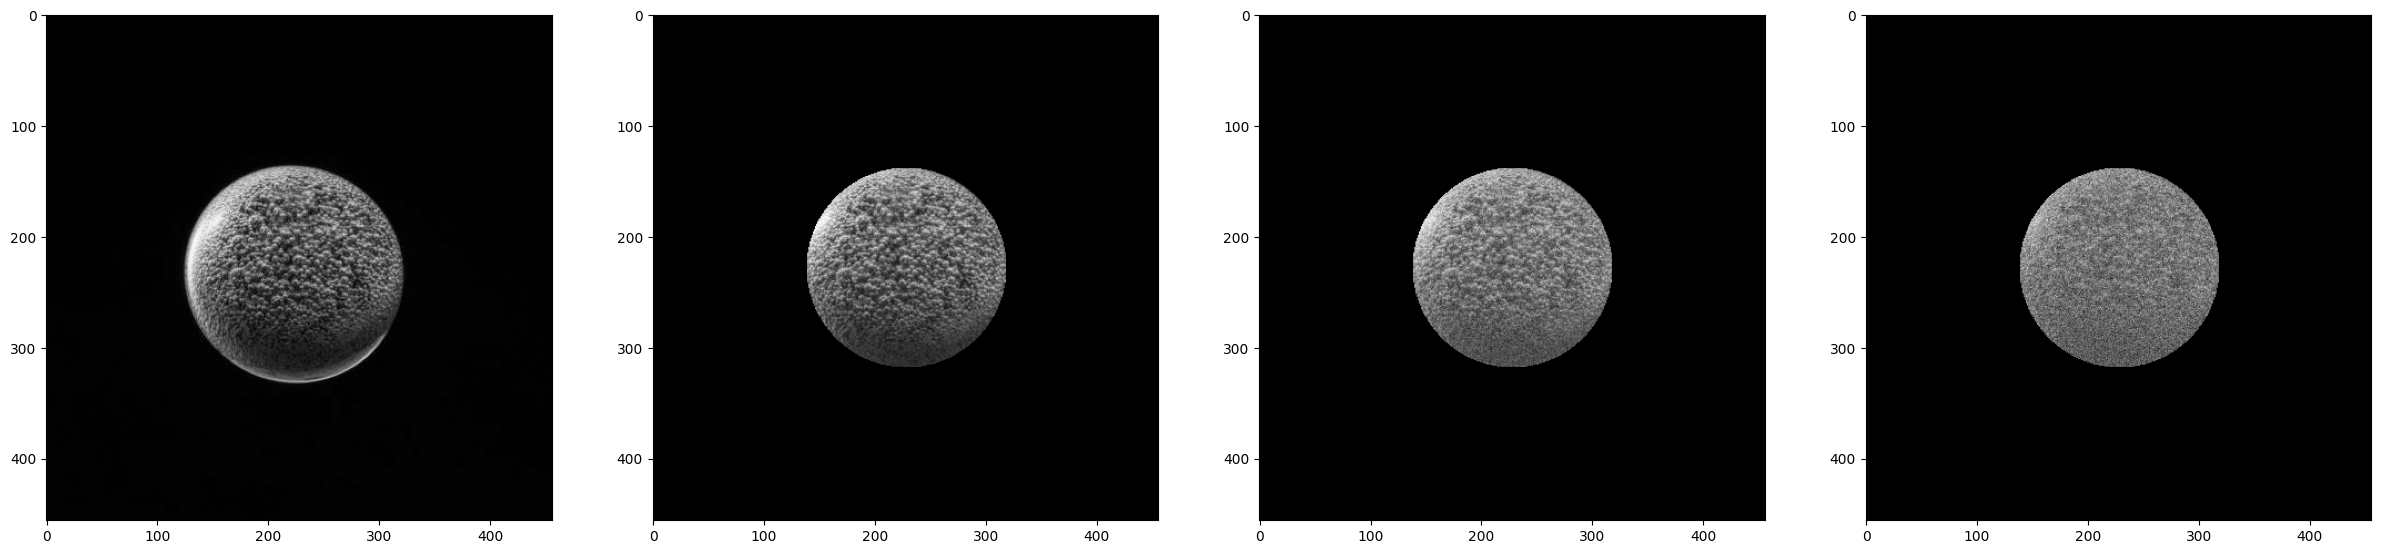

In [61]:
fig, axs = plt.subplots(1,4,figsize=(30, 30))

im_noised_5 = noise(im1,br = 5).astype(np.int32)
im_noised_20 = noise(im1,br = 20).astype(np.int32)
im_noised_50 = noise(im1,br = 50).astype(np.int32)

# Now, you can plot your data on each subplot
axs[0].imshow(im1, cmap = 'gray')
axs[1].imshow( (im_noised_5 - np.min(im_noised_5)) * mask1 , cmap = 'gray')
axs[2].imshow( (im_noised_20 - np.min(im_noised_20)) * mask1, cmap = 'gray')
axs[3].imshow( (im_noised_50 - np.min(im_noised_50)) * mask1, cmap = 'gray')



In [62]:
features_noised = [features]

for i in range(len(im_noised_list)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

## étude par erreur relatif:

On mesurera la stabilité par l'erreur relatif entre la mesure initilae de feature avec la mesure erroné introduit par le bruit $e_{err}^2$, oû :  $e_{rr} = \frac{f_{réelle} - f_{mesuré}}{f_{réelle}}$


l'intuition de la différence est évidente, plus on s'éloigne de la valeur réelle plus c'est moins stable, la division par la valeur réelle est faite pour des raisons de normalisation, afin de comparer tout les features sous le même échelle : l'erreur ainsi donne un pourcentage de combien on s'est éloigné de la valeur réelle, un erreur égale à $100M%$ revient à une estimation 2 fois plus grande que la valeur réelle. 



Le carrée est fait pour effectuer une approche statistique : en effet, Soit T un transformation effectué sur l'image ( un flou par exemple), pour chaque feature i noté $ f_i $ , son estimation est calculé  $\hat{f_i} $ qui est elle même estimé par la moyenne de plusieurs calcule sur plusieurs transformations d'image initiale pour même caratéristique (variance de bruit constante ou taille de noyau de floutage cte)  $\hat{f_i} = \frac{\sum{j=1}^N f_i(T_j(image))}{N} $

On pourra écrire ainsi : 
$$ e_{rr}^2 = \frac{R(f_i,\hat{f_i})}{f_i^2} = \frac{B(f_i,\hat{f_i})^2 + Var(\hat{f_i})}{f_i^2}  =  B_{normalisé}(f_i,\hat{f_i})^2 + VAR_{normalisé}(\hat{f_i})) $$


In [63]:
noise_err_1 = np.square(np.array([(features_noised[i] - features)/features for i in range(150)]))
noise_MSE_1 = [mse(noise_err_1[:,i], 0) for i in range(24)]

### Noise stabiity for image 3

In [65]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list = [noise(im3, 10).astype(np.int32)     for i in range(50)]
im_noised_list +=[noise(im3,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list += [noise(im3,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask3_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_3 = np.square(np.array([(features_noised[i] - features)/features for i in range(150)]))
noise_MSE_3 = [mse(noise_err_3[:,i], 0) for i in range(24)]

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

### Noise stability for image 2

In [66]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im4_ITK, mask4_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_noised_list4 = [noise(im4, 10).astype(np.int32)  for i in range(50)]
im_noised_list4 +=[noise(im4,br = 50).astype(np.int32)  for i in range(50)]
im_noised_list4 += [noise(im4,br = 100).astype(np.int32)  for i in range(50)]

features_noised = [features]

for i in range(len(im_noised_list4)):
  im_noised_ITK_i = sitk.GetImageFromArray(im_noised_list4[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_noised_ITK_i, mask4_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_noised.append( np.array(list(result.values())) )

noise_err_4 = np.square(np.array([(features_noised[i] - features)/features for i in range(150)]))
noise_MSE_4 = [mse(noise_err_4[:,i], 0) for i in range(24)]


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

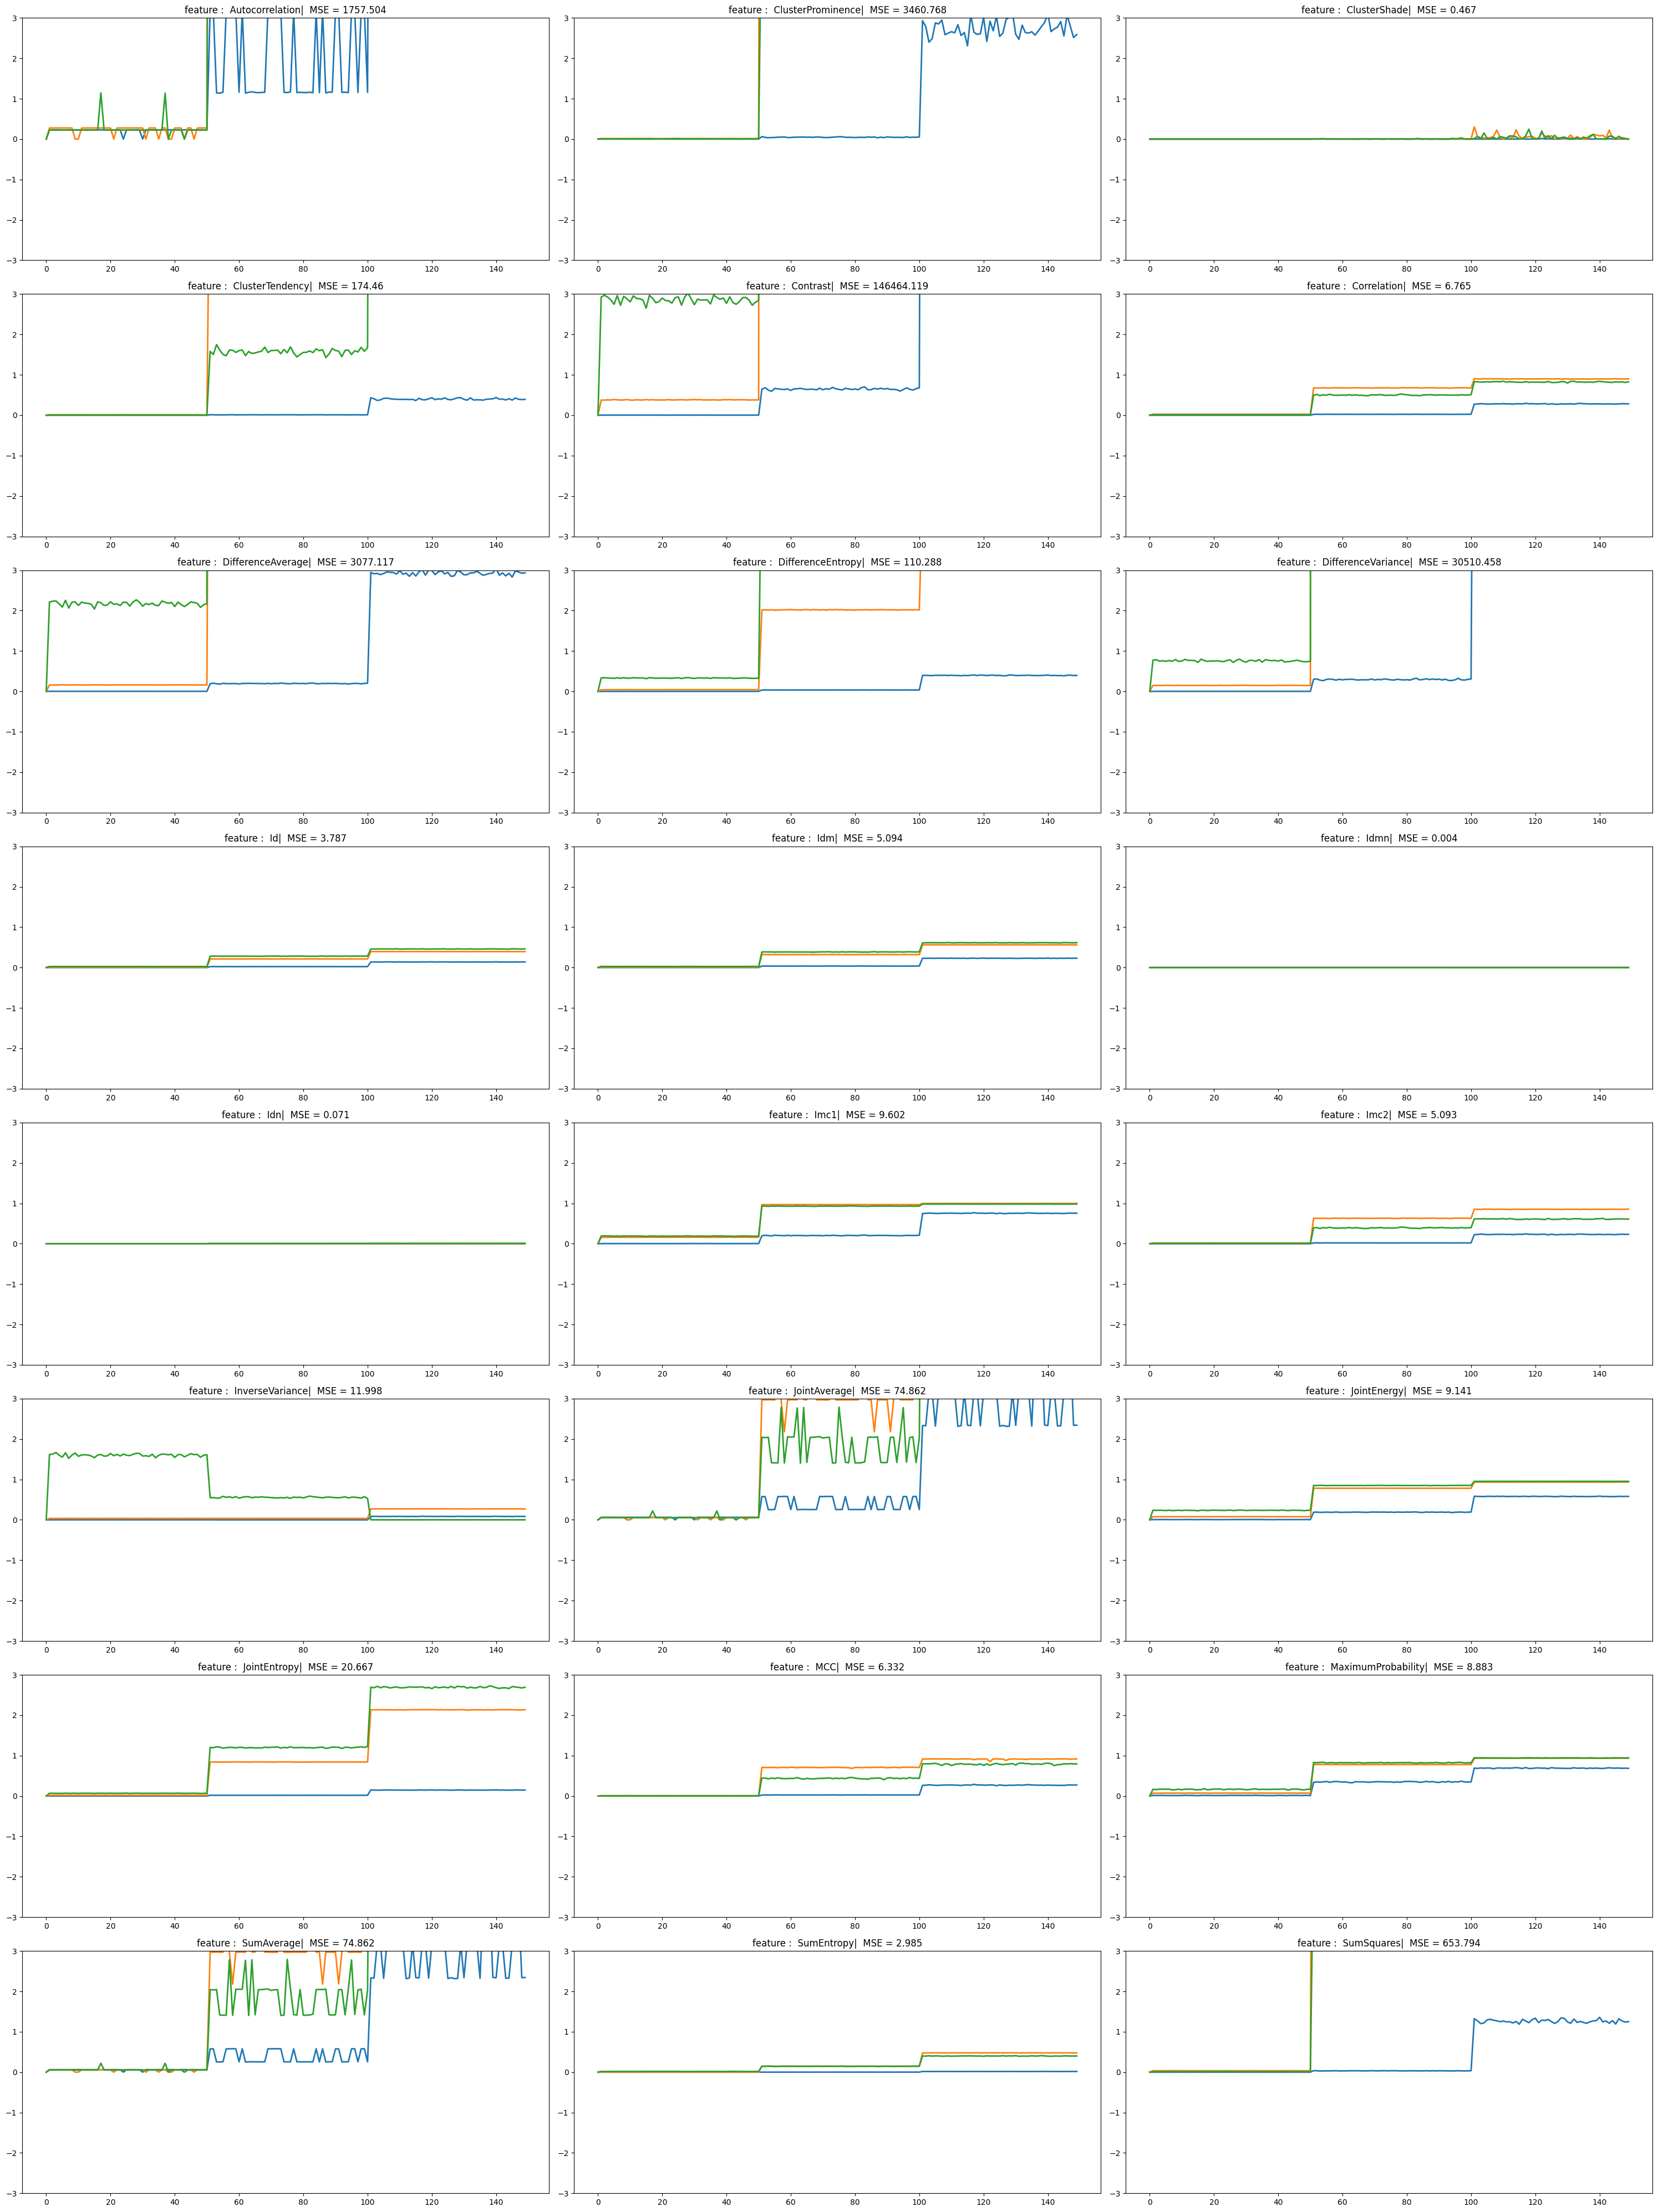

In [67]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))

for i in range(8):
    for j in range(3):
        axs[i, j].plot(noise_err_1[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(noise_err_3[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(noise_err_4[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
    ax.set_ylim(-3, 3)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## variance on noise sigma_b = 5


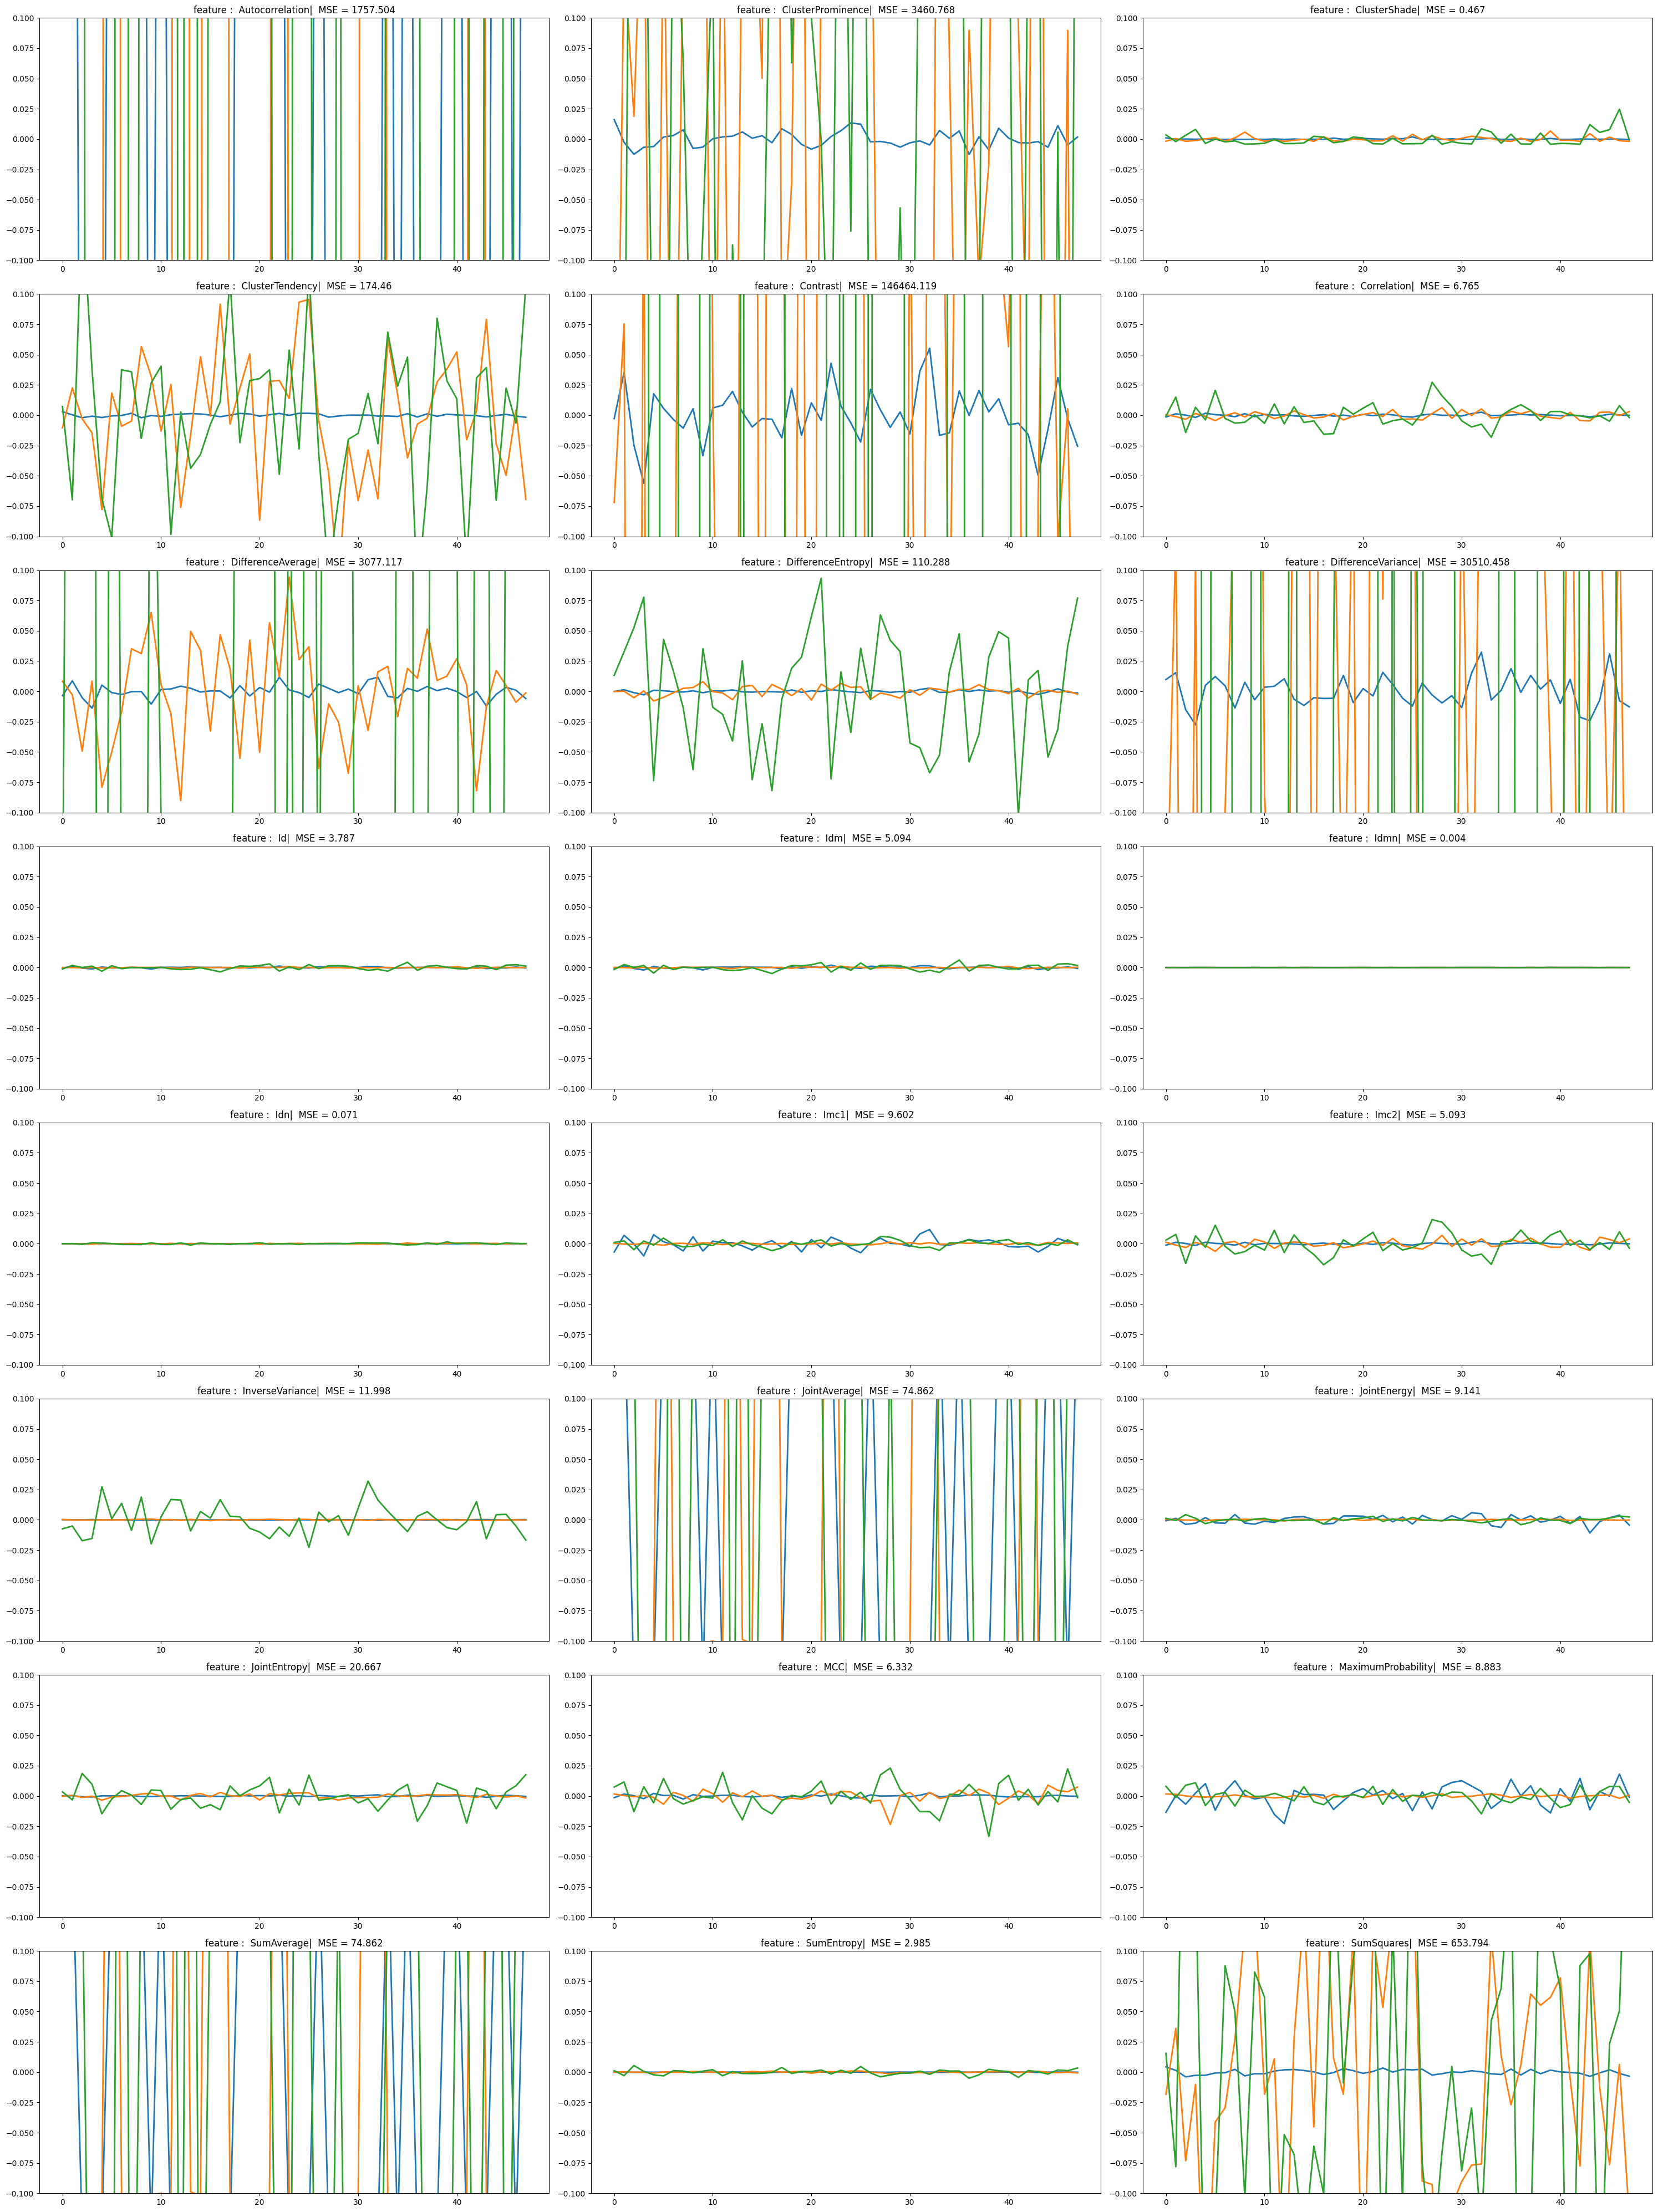

In [68]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (noise_err_1[51:99,3*i+j] - np.mean(noise_err_1[51:99,3*i+j]) )  , linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_3[51:99,3*i+j] - np.mean(noise_err_3[51:99,3*i+j])  ),  linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (noise_err_4[51:99,3*i+j] - np.mean(noise_err_4[51:99,3*i+j]) ), linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(noise_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-0.1, 0.1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Blur Stability

In [69]:
im_flou1 = flou(im1, kernel_size=3)
im_flou2 = flou(im1, kernel_size=5)

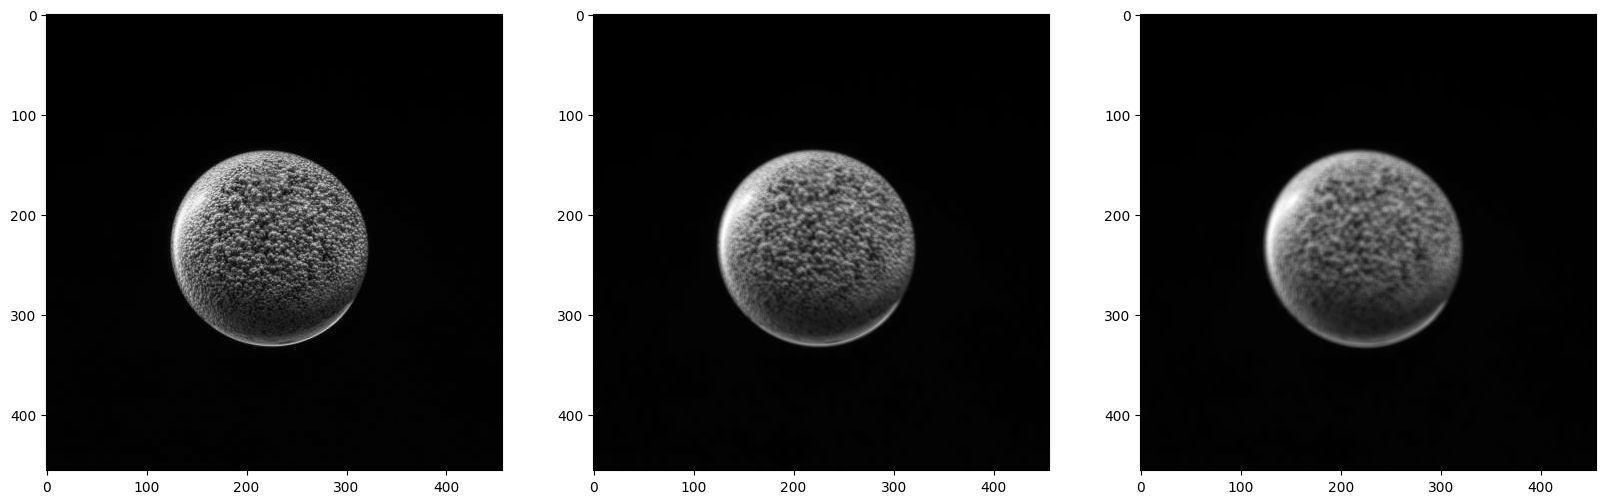

In [70]:
fig, axs = plt.subplots(1,3,figsize=(20, 20))

# Now, you can plot your data on each subplot
axs[0].imshow(im1, cmap = 'gray')

axs[1].imshow(im_flou1, cmap = 'gray')

axs[2].imshow(im_flou2, cmap = 'gray')



### Stabilité par Flou:

In [71]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_1 = np.square(np.array([(features_blurred[i] - features)/features for i in range(100)]))
blurr_MSE_1   = [mse(blurr_error_1[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [72]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im3_ITK, mask3_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_3 = np.square(np.array([(features_blurred[i] - features)/features for i in range(100)]))
blurr_MSE_3   = [mse(blurr_error_3[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [73]:
#featureVector = extractor.execute(im_ITK, mask_ITK) // this computes all features

#compute only GLCM features

glcmFeatures = glcm.RadiomicsGLCM(im4_ITK, mask4_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()


features = np.array(list(result.values()))
args = list(result.keys())

im_blurred_list =  [flou(im1,kernel_size=3).astype(np.int32) for i in range(50)]
im_blurred_list += [flou(im1,kernel_size=5).astype(np.int32) for i in range(50)]


features_blurred = [features]

for i in range(len(im_blurred_list)):
  im_blurred_ITK_i = sitk.GetImageFromArray(im_blurred_list[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_blurred_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features_blurred.append( np.array(list(result.values())) )

blurr_error_4 = np.square(np.array([(features_blurred[i] - features)/features for i in range(100)]))
blurr_MSE_4   = [mse(blurr_error_4[:,i], 0) for i in range(24)]



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

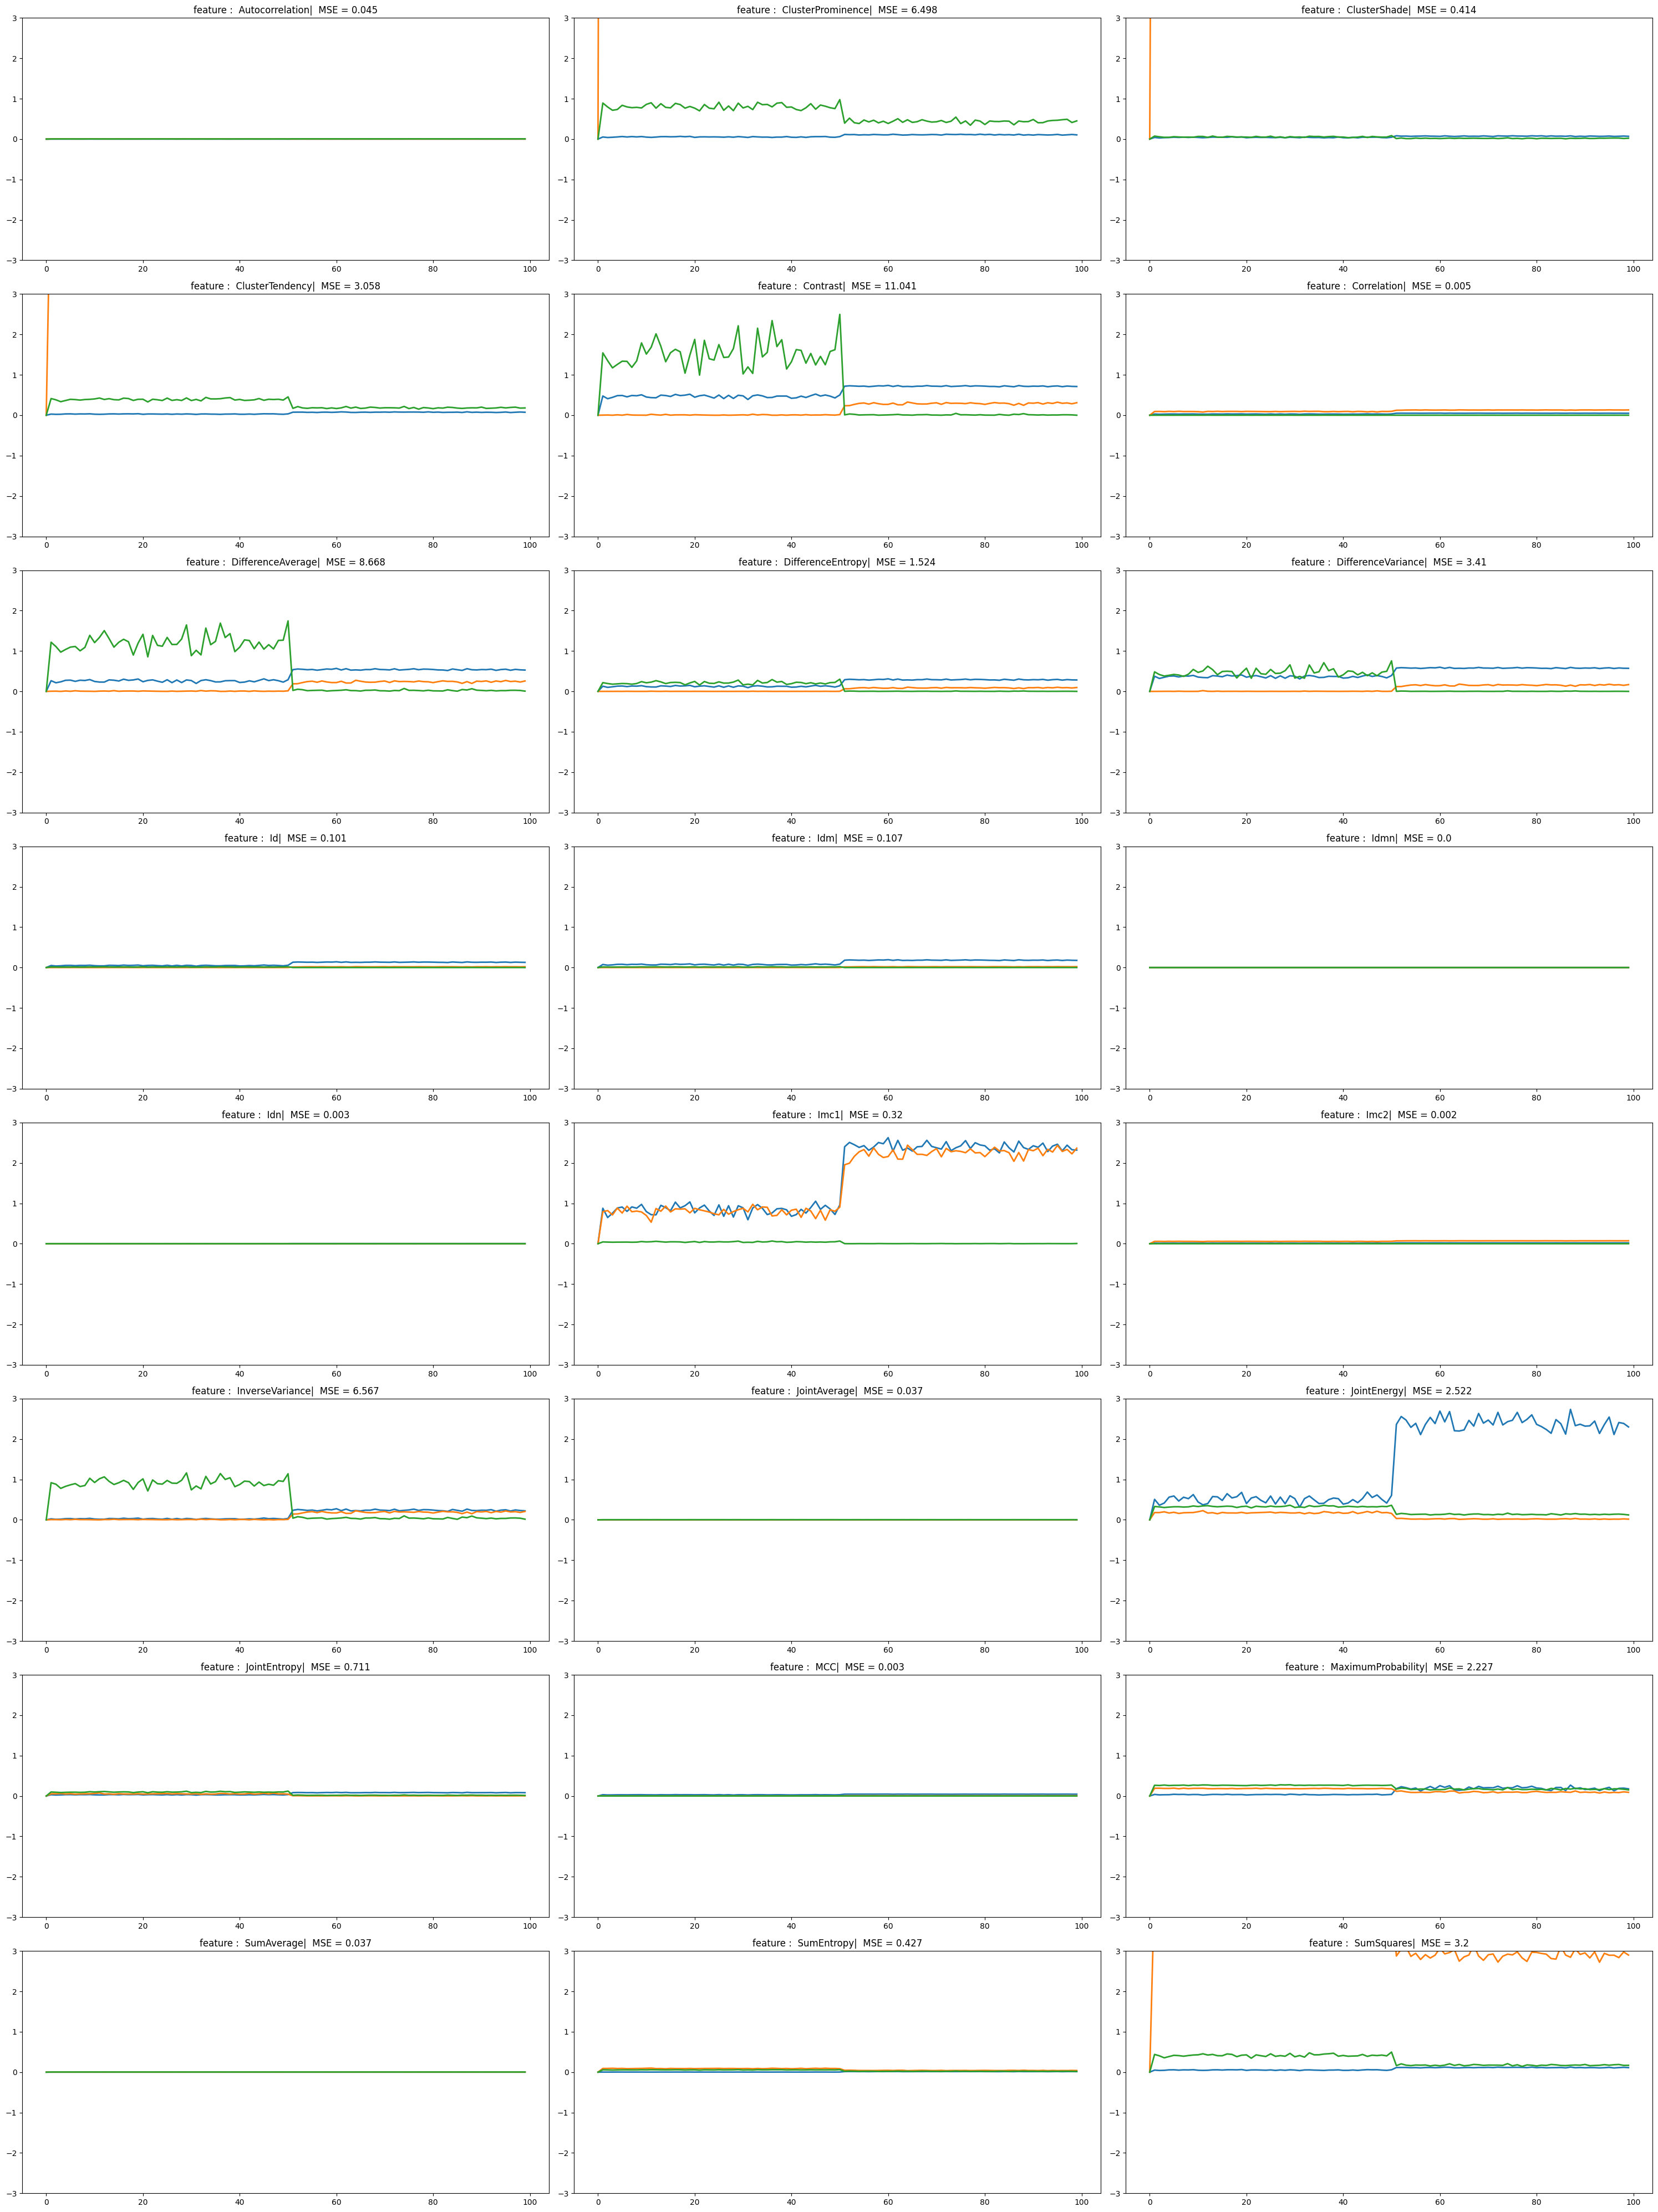

In [74]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot(blurr_error_1[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_3[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(blurr_error_4[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
    ax.set_ylim(-3, 3)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

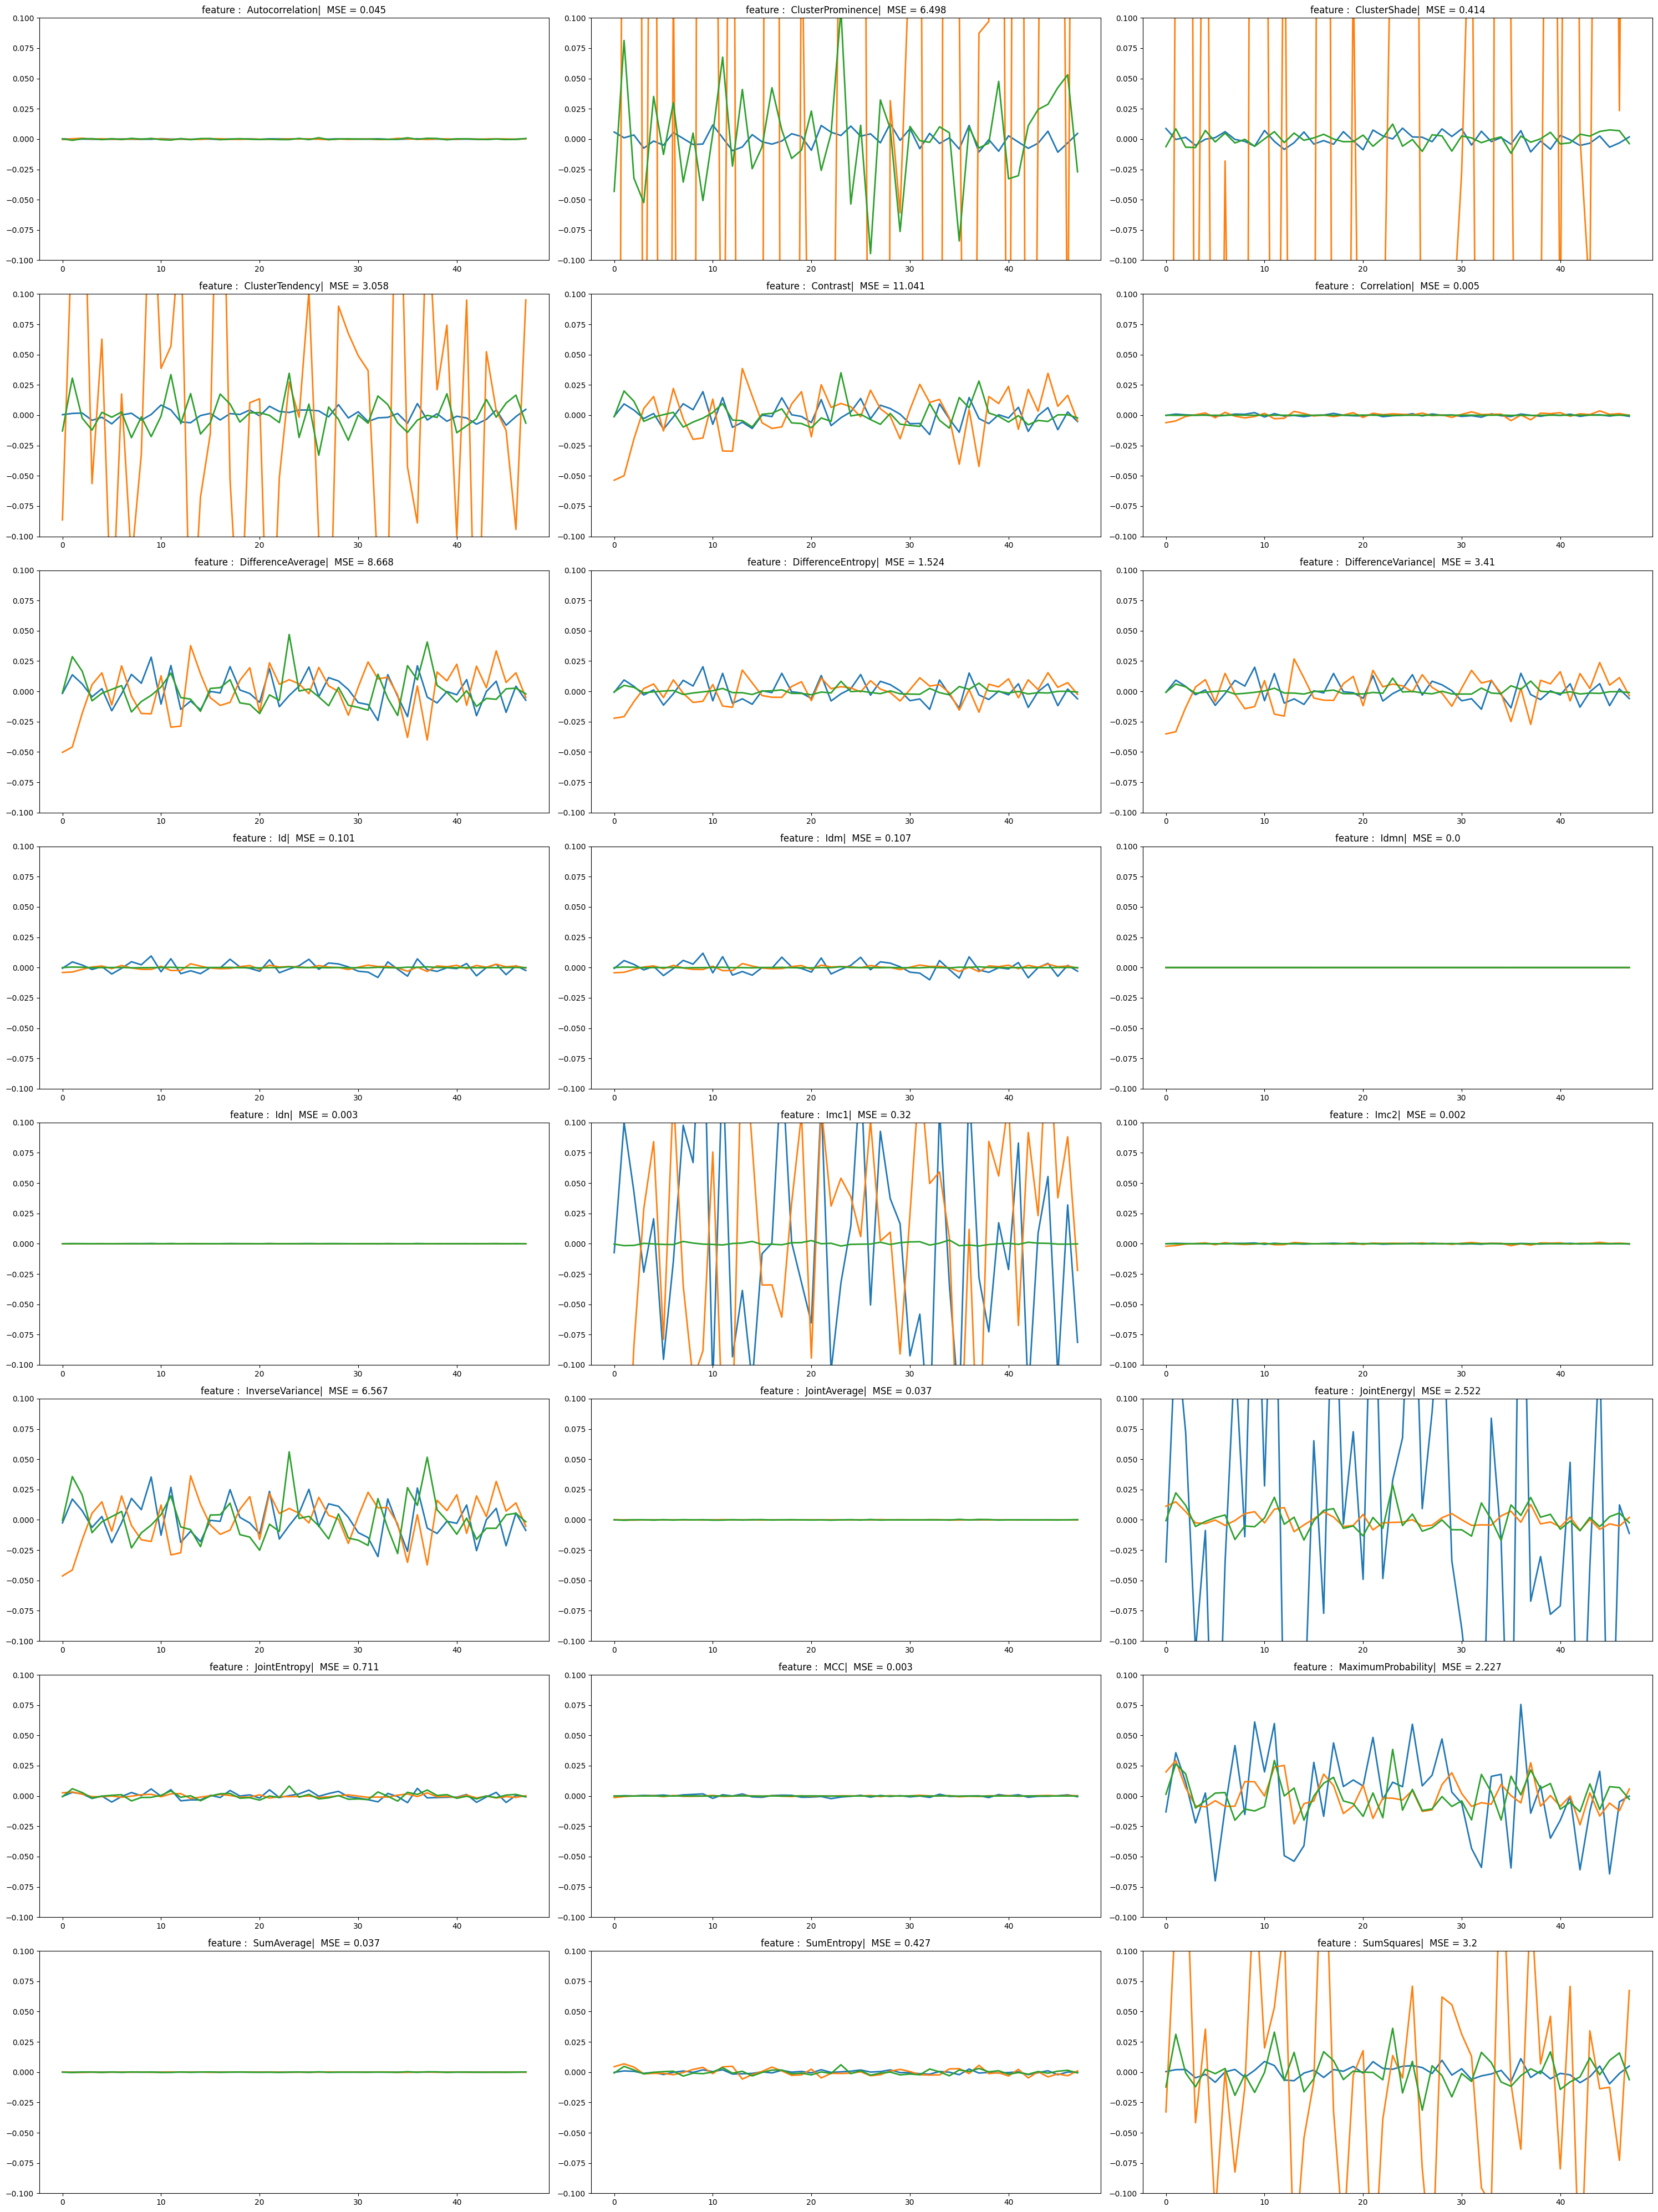

In [75]:
fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot( (blurr_error_1[51:99,3*i+j] - np.mean(blurr_error_1[51:99,3*i+j]) )  , linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_3[51:99,3*i+j] - np.mean(blurr_error_3[51:99,3*i+j])  ),  linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_3[3*i+j], 3) ))
        axs[i, j].plot(  (blurr_error_4[51:99,3*i+j] - np.mean(blurr_error_4[51:99,3*i+j]) ), linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_4[3*i+j], 3) ))

for ax in axs.flat:
   ax.set_ylim(-0.1, 0.1)


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

##### Les grandeurs suivantes sont normalisé:

In [76]:
BiasSq_noise5  = np.array([np.mean(noise_err_1[1:51,i]) for i in range(24)])
BiasSq_noise20 = np.array([np.mean(noise_err_1[52:101,i]) for i in range(24)])
BiasSq_noise50 = np.array([np.mean(noise_err_1[102:-1,i]) for i in range(24)])

Var_noise5      = [mse(noise_err_1[1:51,i],np.mean(noise_err_1[1:51,i])) for i in range(24)] 
Var_noise20     = [mse(noise_err_1[52:101,i],np.mean(noise_err_1[52:101,i])) for i in range(24)] 
Var_noise50     = [mse(noise_err_1[102:-1,i],np.mean(noise_err_1[102:-1,i])) for i in range(24)] 

BiasSq_FlouMoyen   = np.array([np.mean(blurr_error_1[1:51,i]) for i in range(24)])
BiasSq_FlouFort    = np.array([np.mean(blurr_error_1[52:-1,i]) for i in range(24)])

Var_FlouMoyen   = [mse(blurr_error_1[1:51,i],np.mean(blurr_error_1[1:51,i])) for i in range(24)] 
Var_FlouFor     = [mse(blurr_error_1[52:-1,i],np.mean(blurr_error_1[52:-1,i])) for i in range(24)] 


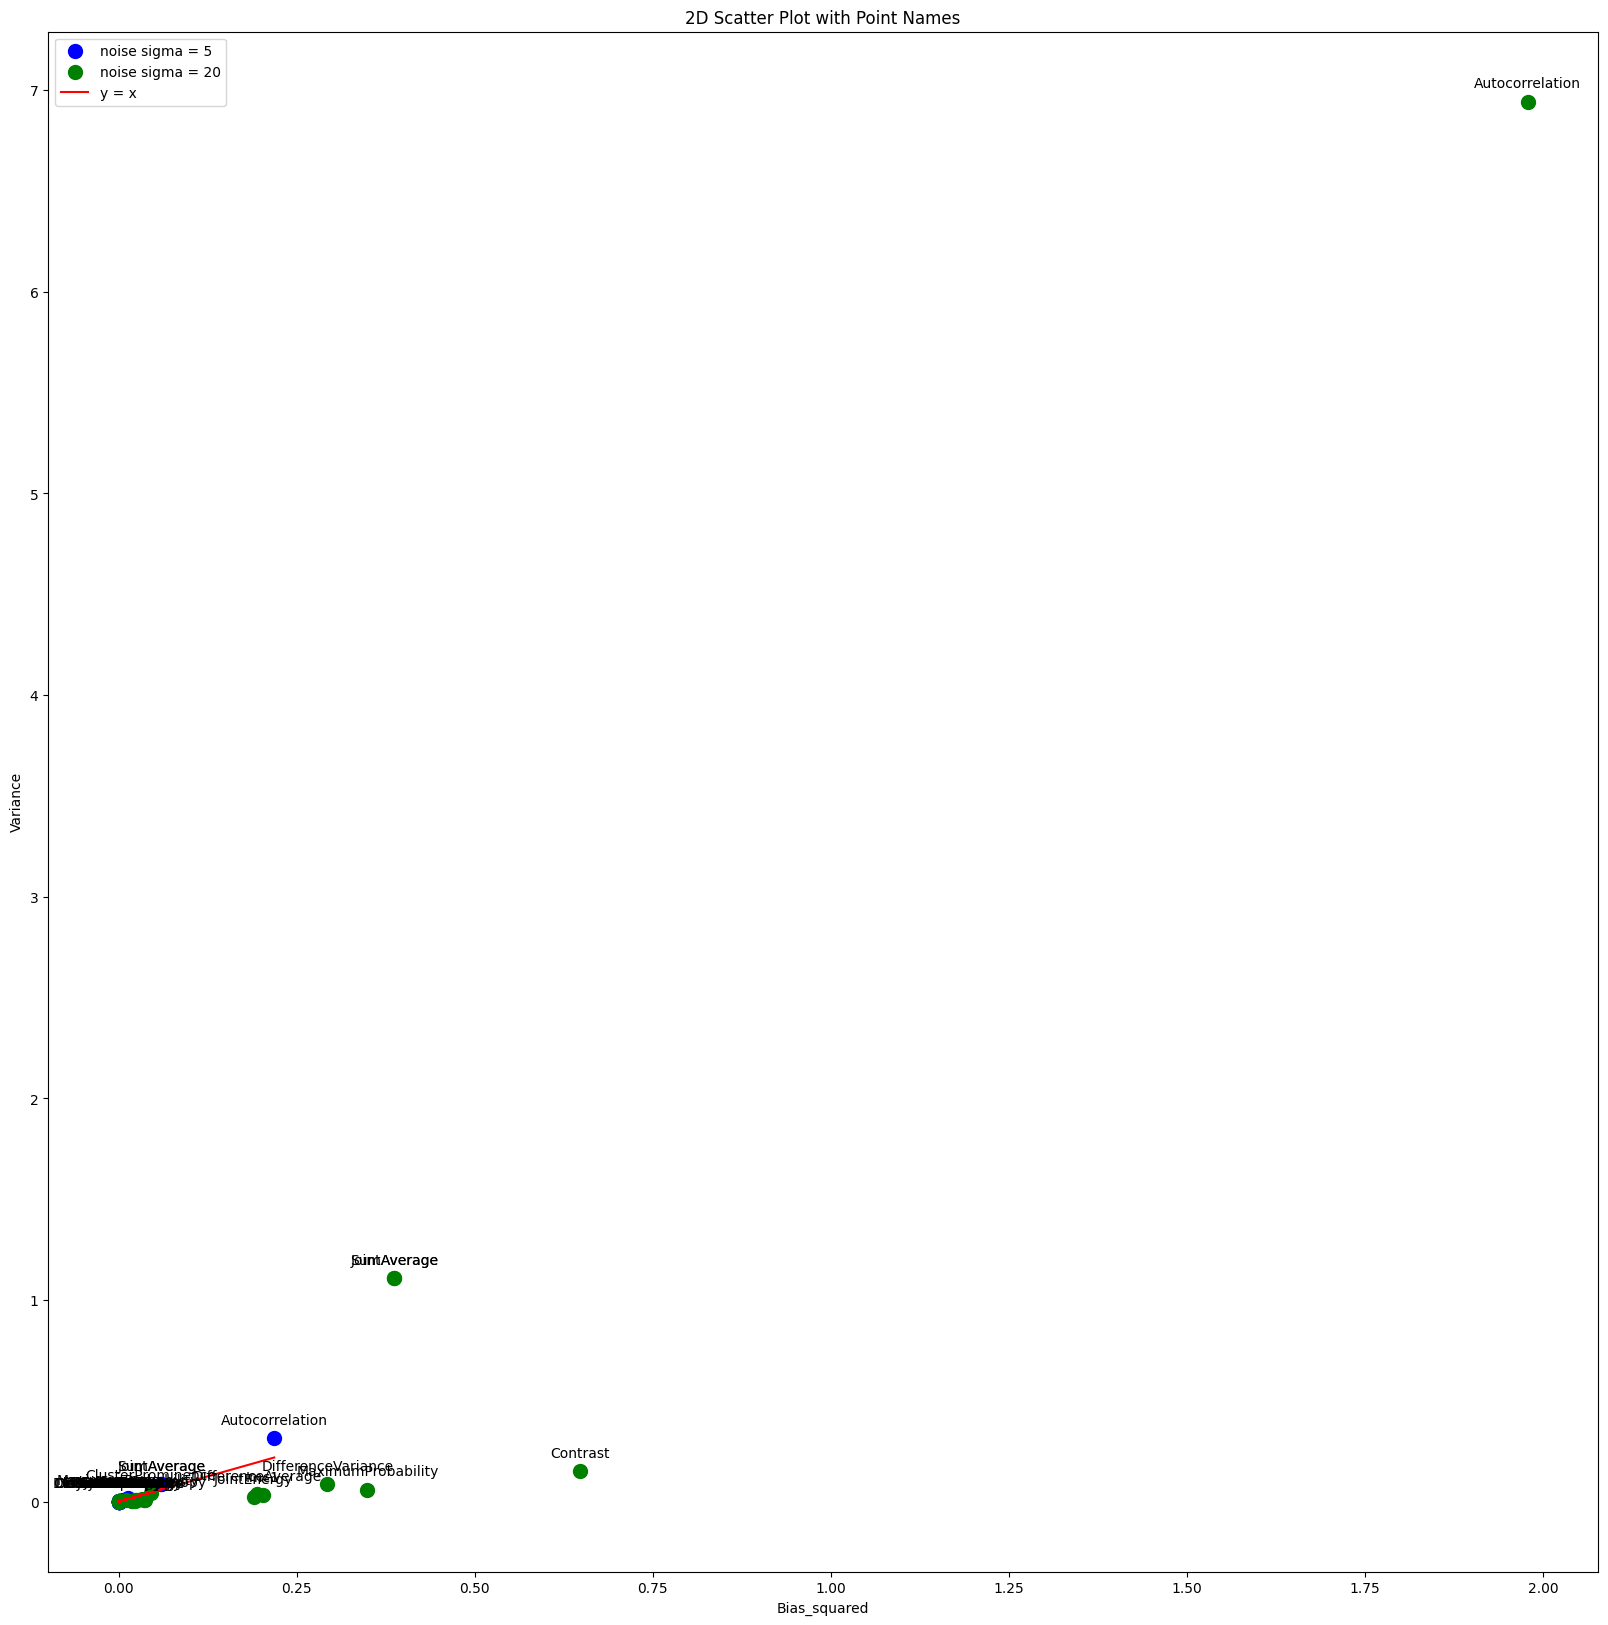

In [77]:
plt.figure(figsize=(20,20))
# Create a scatter plot
plt.scatter(BiasSq_noise5, Var_noise5, label='noise sigma = 5', s=100, c='blue')
plt.scatter(BiasSq_noise20, Var_noise20, label='noise sigma = 20', s=100, c='green')
#plt.scatter(BiasSq_noise50, Var_noise50, label='noise sigma = 50', s=100, c='red')
# plt.scatter(BiasSq_FlouMoyen, Var_FlouMoyen, label='flou moyen', s=100, c='purple')
# plt.scatter(BiasSq_FlouFort, Var_FlouFor, label='flou fort', s=100, c='peru')

# Annotate each point with its corresponding name
for i, txt in enumerate(args):
    plt.annotate(txt, (BiasSq_noise5[i], Var_noise5[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_noise20[i], Var_noise20[i]), textcoords="offset points", xytext=(0, 10), ha='center')
#    plt.annotate(txt, (BiasSq_noise50[i], Var_noise50[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    # plt.annotate(txt, (BiasSq_FlouMoyen[i], Var_FlouMoyen[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    # plt.annotate(txt, (BiasSq_FlouFort[i], Var_FlouFor[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.plot(BiasSq_noise5, BiasSq_noise5, color='red', label='y = x')
# Set labels and title
plt.xlabel('Bias_squared')
plt.ylabel('Variance')
plt.title('2D Scatter Plot with Point Names')

# Show the legend
plt.legend()

# Display the plot
plt.show()

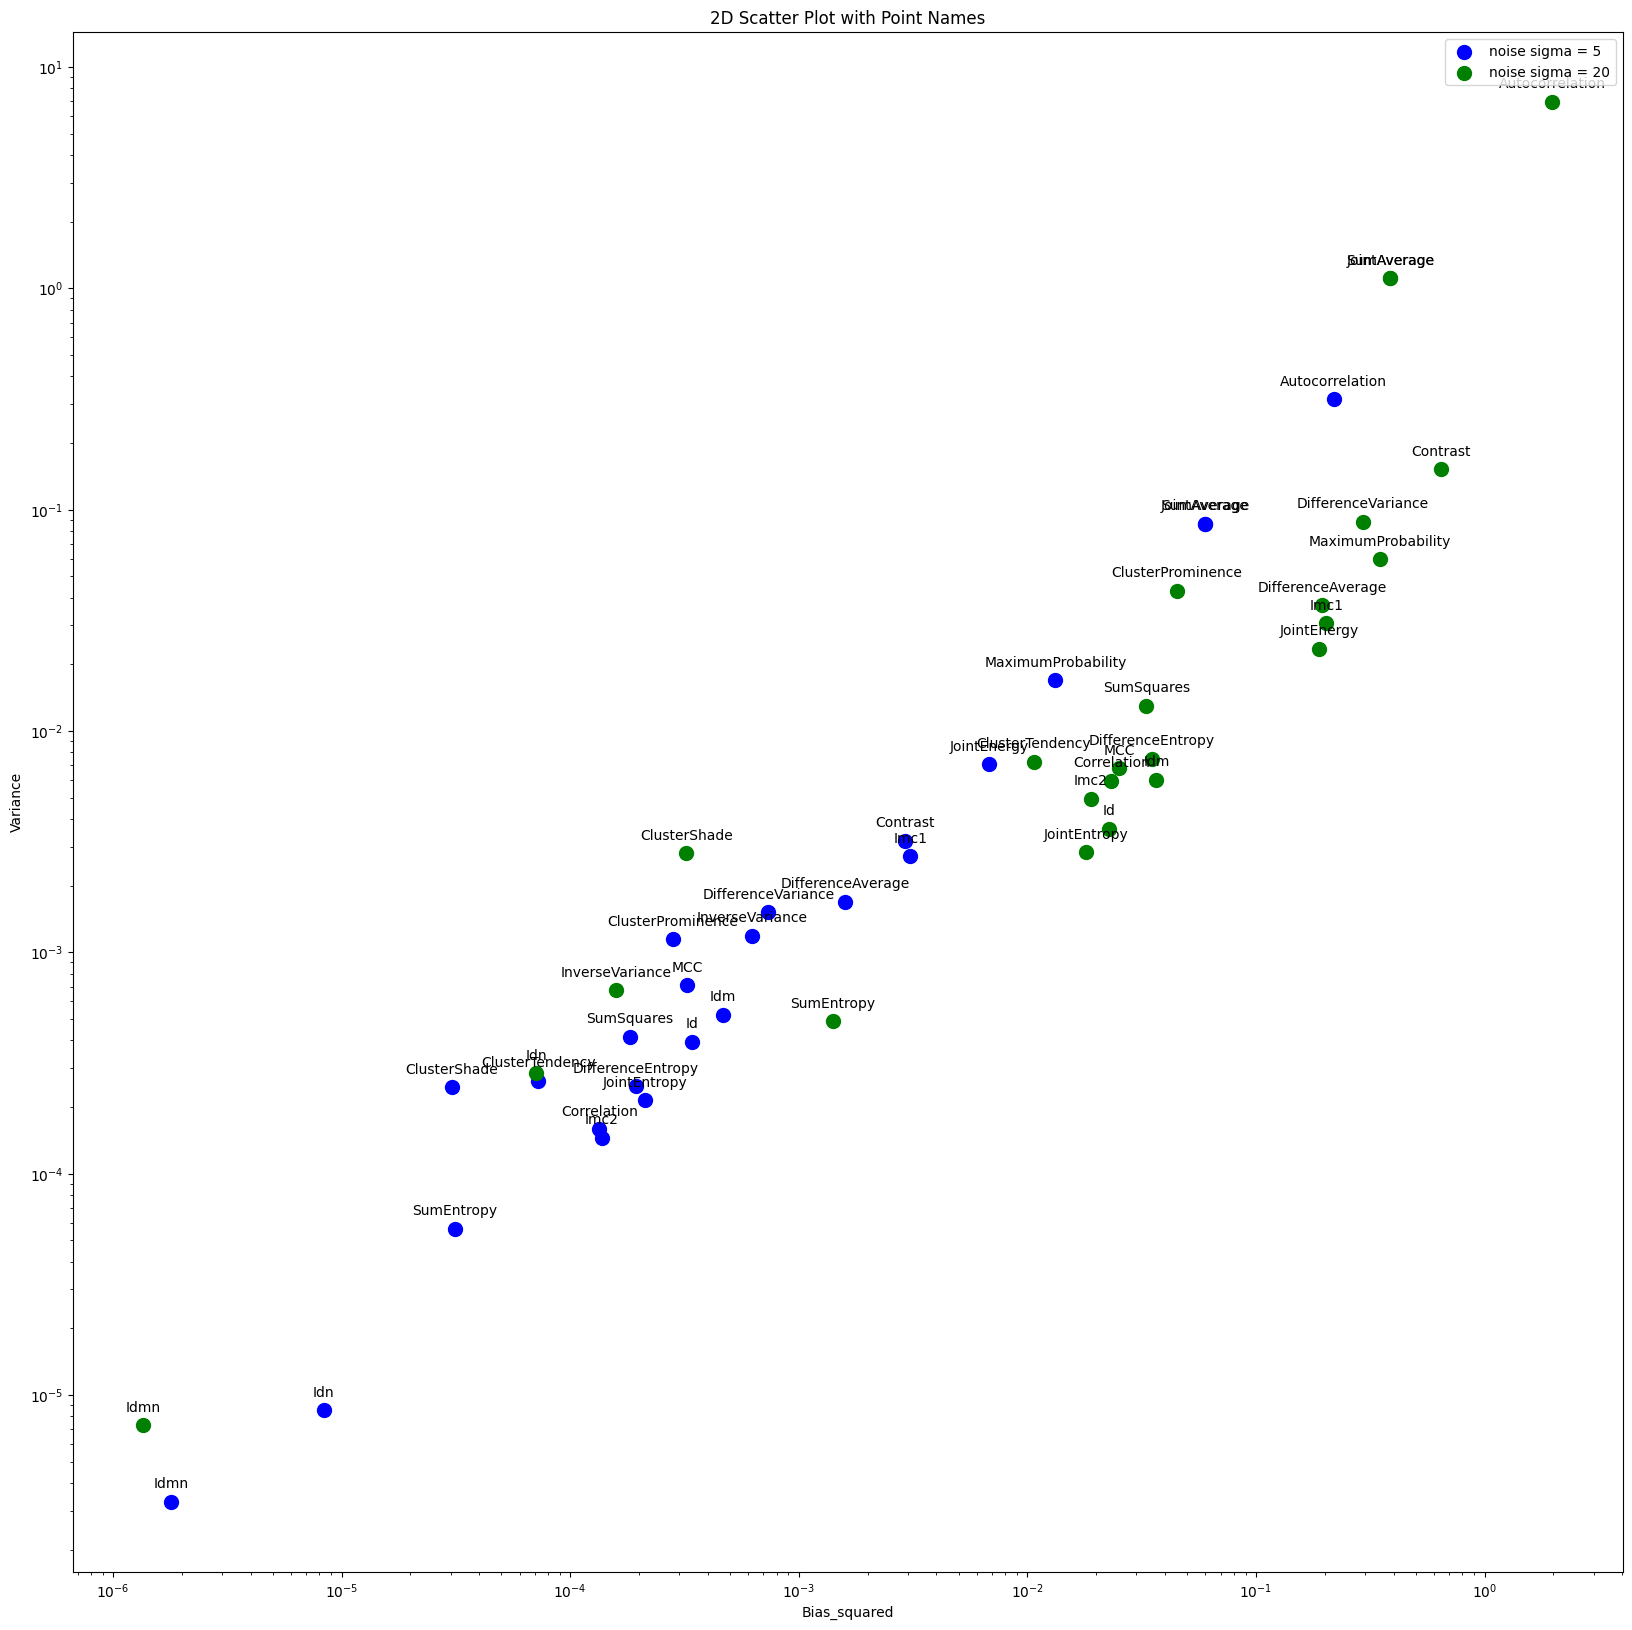

In [78]:
plt.figure(figsize=(20,20))
# Create a scatter plot
plt.scatter(BiasSq_noise5, Var_noise5, label='noise sigma = 5', s=100, c='blue')
plt.scatter(BiasSq_noise20, Var_noise20, label='noise sigma = 20', s=100, c='green')
#plt.scatter(BiasSq_noise50, Var_noise50, label='noise sigma = 50', s=100, c='red')
# plt.scatter(BiasSq_FlouMoyen, Var_FlouMoyen, label='flou moyen', s=100, c='purple')
# plt.scatter(BiasSq_FlouFort, Var_FlouFor, label='flou fort', s=100, c='peru')

# Annotate each point with its corresponding name
for i, txt in enumerate(args):
    plt.annotate(txt, (BiasSq_noise5[i], Var_noise5[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_noise20[i], Var_noise20[i]), textcoords="offset points", xytext=(0, 10), ha='center')
#    plt.annotate(txt, (BiasSq_noise50[i], Var_noise50[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    # plt.annotate(txt, (BiasSq_FlouMoyen[i], Var_FlouMoyen[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    # plt.annotate(txt, (BiasSq_FlouFort[i], Var_FlouFor[i]), textcoords="offset points", xytext=(0, 10), ha='center')


plt.xscale('log')
plt.yscale('log')
# Set labels and title
plt.xlabel('Bias_squared')
plt.ylabel('Variance')
plt.title('2D Scatter Plot with Point Names')

# Show the legend
plt.legend()

# Display the plot
plt.show()

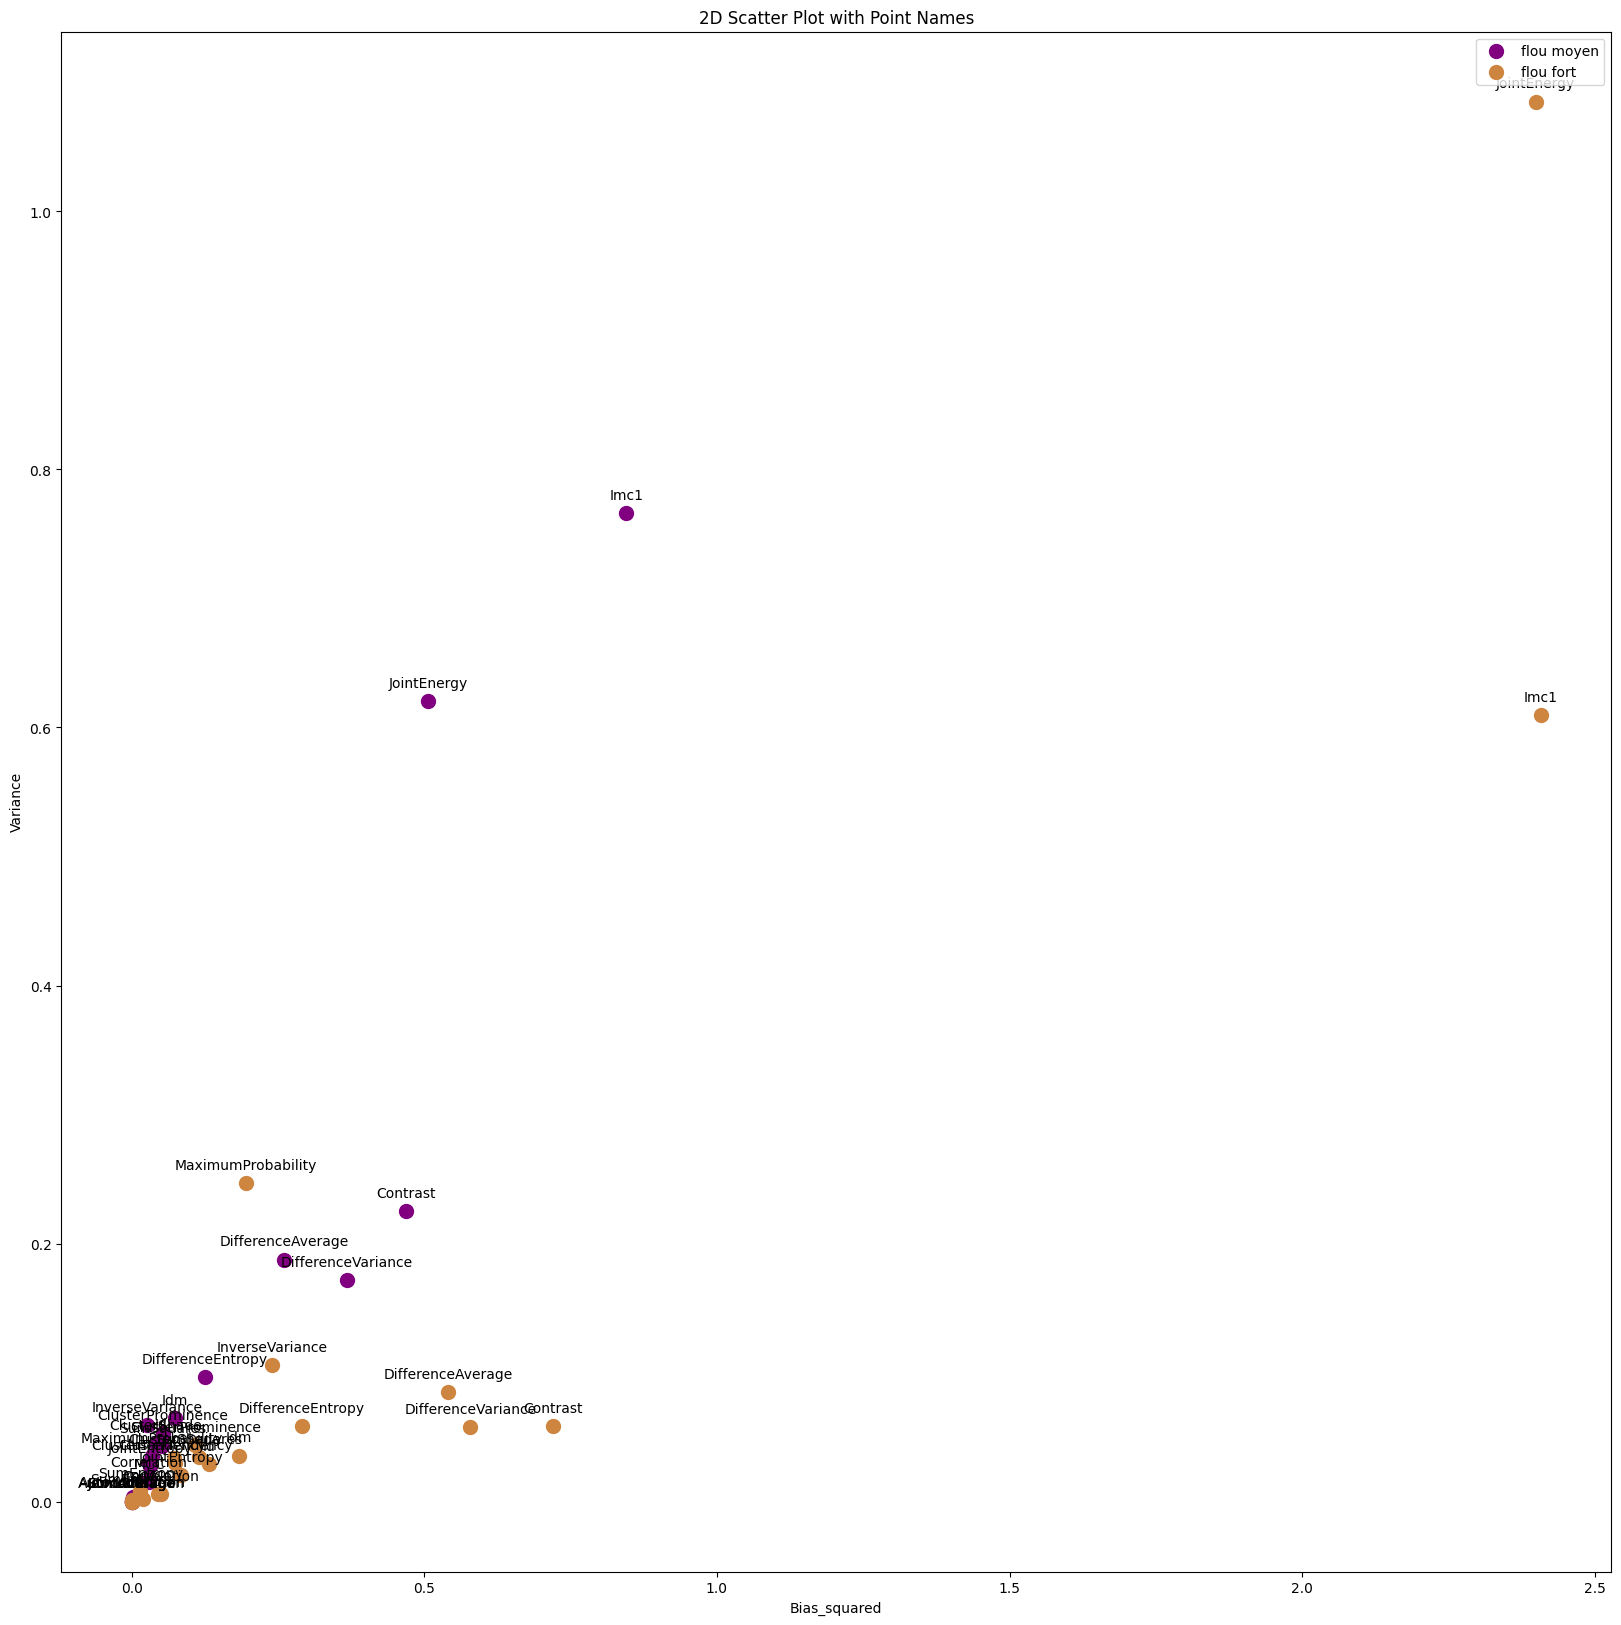

In [79]:
plt.figure(figsize=(20,20))
# Create a scatter plot
# plt.scatter(BiasSq_noise5, Var_noise5, label='noise sigma = 5', s=100, c='blue')
# plt.scatter(BiasSq_noise20, Var_noise20, label='noise sigma = 20', s=100, c='green')
#plt.scatter(BiasSq_noise50, Var_noise50, label='noise sigma = 50', s=100, c='red')
plt.scatter(BiasSq_FlouMoyen, Var_FlouMoyen, label='flou moyen', s=100, c='purple')
plt.scatter(BiasSq_FlouFort, Var_FlouFor, label='flou fort', s=100, c='peru')

# Annotate each point with its corresponding name
for i, txt in enumerate(args):
#     plt.annotate(txt, (BiasSq_noise5[i], Var_noise5[i]), textcoords="offset points", xytext=(0, 10), ha='center')
#     plt.annotate(txt, (BiasSq_noise20[i], Var_noise20[i]), textcoords="offset points", xytext=(0, 10), ha='center')
# #    plt.annotate(txt, (BiasSq_noise50[i], Var_noise50[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_FlouMoyen[i], Var_FlouMoyen[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_FlouFort[i], Var_FlouFor[i]), textcoords="offset points", xytext=(0, 10), ha='center')


# Set labels and title
plt.xlabel('Bias_squared')
plt.ylabel('Variance')
plt.title('2D Scatter Plot with Point Names')

# Show the legend
plt.legend()

# Display the plot
plt.show()

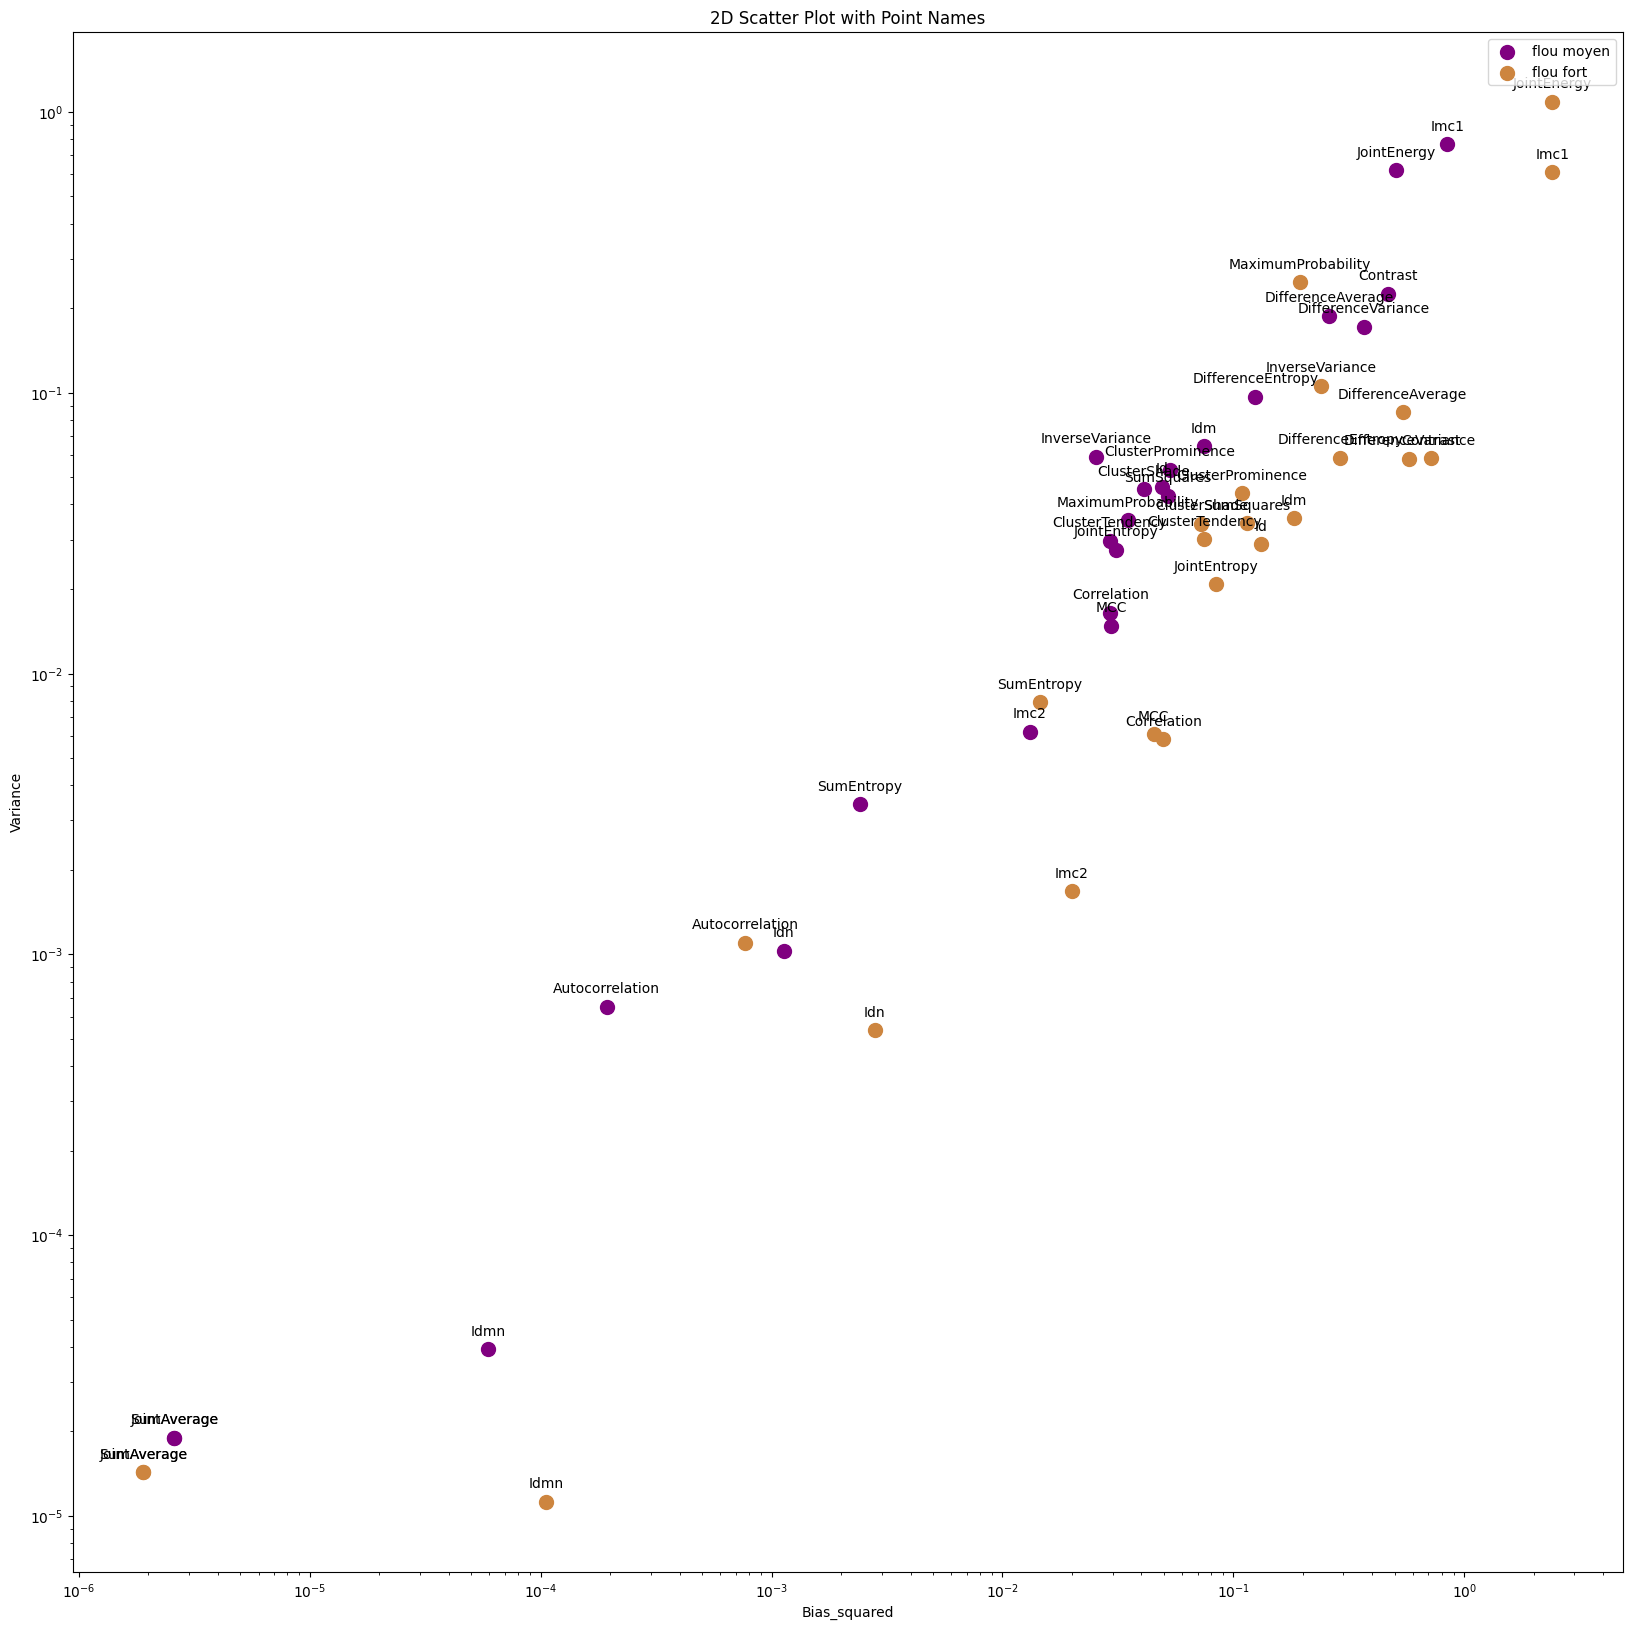

In [80]:
plt.figure(figsize=(20,20))
# Create a scatter plot
# plt.scatter(BiasSq_noise5, Var_noise5, label='noise sigma = 5', s=100, c='blue')
# plt.scatter(BiasSq_noise20, Var_noise20, label='noise sigma = 20', s=100, c='green')
#plt.scatter(BiasSq_noise50, Var_noise50, label='noise sigma = 50', s=100, c='red')
plt.scatter(BiasSq_FlouMoyen, Var_FlouMoyen, label='flou moyen', s=100, c='purple')
plt.scatter(BiasSq_FlouFort, Var_FlouFor, label='flou fort', s=100, c='peru')

# Annotate each point with its corresponding name
for i, txt in enumerate(args):
#     plt.annotate(txt, (BiasSq_noise5[i], Var_noise5[i]), textcoords="offset points", xytext=(0, 10), ha='center')
#     plt.annotate(txt, (BiasSq_noise20[i], Var_noise20[i]), textcoords="offset points", xytext=(0, 10), ha='center')
# #    plt.annotate(txt, (BiasSq_noise50[i], Var_noise50[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_FlouMoyen[i], Var_FlouMoyen[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(txt, (BiasSq_FlouFort[i], Var_FlouFor[i]), textcoords="offset points", xytext=(0, 10), ha='center')


plt.xscale('log')
plt.yscale('log')
# Set labels and title
plt.xlabel('Bias_squared')
plt.ylabel('Variance')
plt.title('2D Scatter Plot with Point Names')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# PipeLine Normalisation des features [0,1]

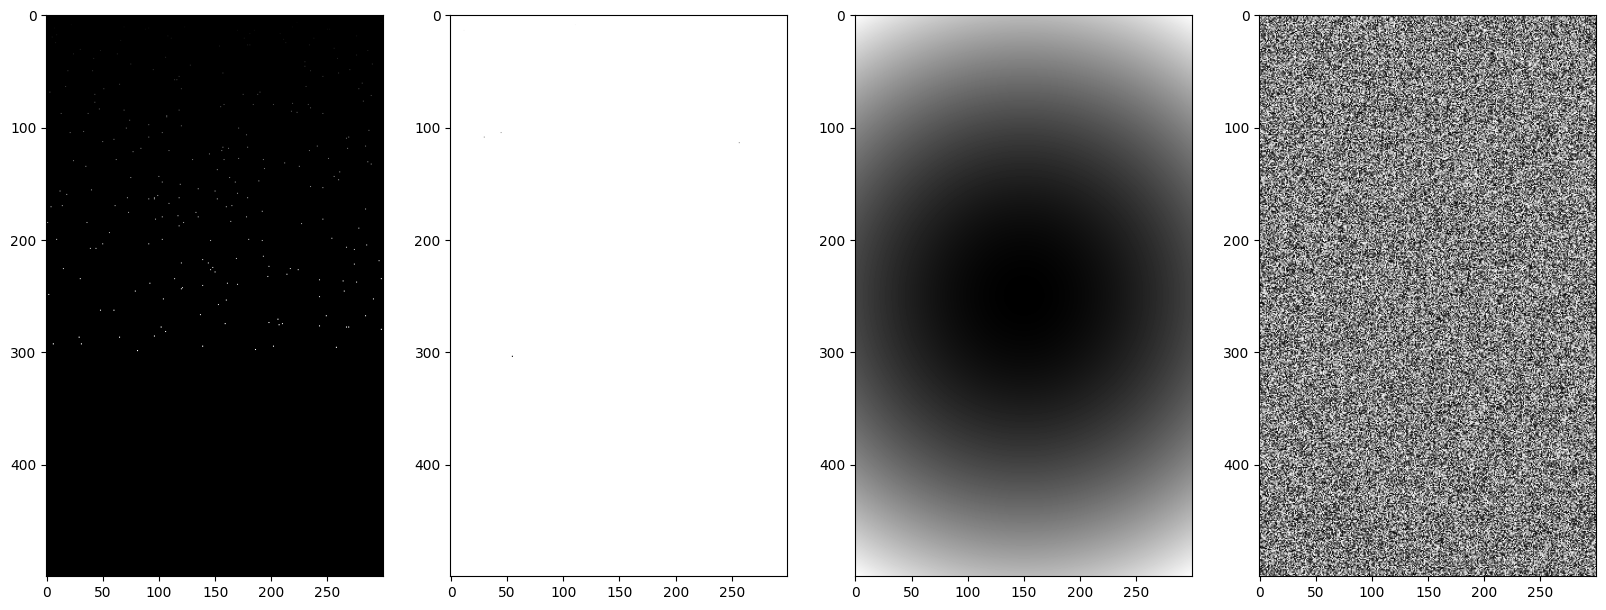

In [138]:
n,p = 500,300

im_cte1 = np.zeros((n,p))
im_cte2 = np.ones((n,p))*255

for k in range(256):
    i,j = np.random.randint(0, min(n,p), size=2)
    im_cte1[i,j] = i
    im_cte2[i,j] = 255 - i

O = [p/2,n/2]

im_regul = [[255*( (i-O[0])**2 +(j-O[1])**2 ) for i in range(p)] for j in range(n)] 



# im = sitk.GetArrayViewFromImage(im_ITK)

# img_cte_255   = np.ones((n,p))*255
# img_cte_000   = np.zeroes((n,p))
img_rand  = np.random.uniform(0, 255, size=(n, p)) # tochange depending on coding type


fig, axs = plt.subplots(1,4,figsize=(20, 20))

# Now, you can plot your data on each subplot
axs[0].imshow(im_cte1, cmap = 'gray')

axs[1].imshow(im_cte_2, cmap = 'gray')

axs[2].imshow(im_regul, cmap = 'gray')

axs[3].imshow(img_rand, cmap = 'gray')




In [139]:
im1_ITK.GetSize()

(456, 456)

In [131]:
def extreme_Features(im_ITK, mask_ITK):

    n,p = im_ITK.GetSize()

    im_cte1 = np.zeros((n,p))
    im_cte2 = np.ones((n,p))*255

    for k in range(256):
        i,j = np.random.randint(0, min(n,p), size=2)
        im_cte1[i,j] = i
        im_cte2[i,j] = 255 - i

    O = [int(n/2),int(p/2)]

    im_regul = [[255*( (i-O[0])**2 +(j-O[1])**2 ) for i in range(n)] for j in range(p)]
    
    img_rand  = np.random.uniform(0, 255, size=(n, p)) # tochange depending on coding type



# im = sitk.GetArrayViewFromImage(im_ITK)

# img_cte_255   = np.ones((n,p))*255
# img_cte_000   = np.zeroes((n,p))

    # im = sitk.GetArrayViewFromImage(im_ITK)

    # img_cte_255   = np.ones((n,p))*255
    # img_cte_000   = np.zeroes((n,p))
    img_rand  = np.random.uniform(0, 255, size=(n, p)) # tochange depending on coding type

    im_cte1_ITK  = sitk.GetImageFromArray(im_cte1)
    im_cte2_ITK  = sitk.GetImageFromArray(im_cte2)
    im_regul_ITK = sitk.GetImageFromArray(im_regul)
    img_rand_ITK = sitk.GetImageFromArray(img_rand)

    glcmFeatures = glcm.RadiomicsGLCM(im_cte1_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    cte1_f = np.array(list(glcmFeatures.execute().values() ))

    glcmFeatures = glcm.RadiomicsGLCM(im_cte2_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    cte2_f = np.array(list(glcmFeatures.execute().values() ))

    
    glcmFeatures = glcm.RadiomicsGLCM(img_rand_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    Urand_f = np.array(list(glcmFeatures.execute().values() ))

    glcmFeatures = glcm.RadiomicsGLCM(im_regul_ITK, mask_ITK)
    glcmFeatures.enableAllFeatures()
    regul_f = np.array(list(glcmFeatures.execute().values() ))

    extreme_features = [cte1_f, -cte1_f, cte2_f, -cte2_f, Urand_f, -Urand_f, regul_f, -regul_f]

    return extreme_features


In [132]:
extreme_Features_im1 = np.array(extreme_Features(im1_ITK, mask1_ITK))

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


MemoryError: 

In [ ]:
im_transformed   = [flou(im1,kernel_size=3).astype(np.int32) for i in range(5)]
im_transformed  += [noise(im1, br = 10).astype(np.int32) for i in range(5)]
im_transformed  += [flou(im1, kernel_size=5).astype(np.int32) for i in range(5)]
im_transformed  += [noise(im1, br = 20).astype(np.int32) for i in range(5)]

features = [] 

for i in range(len(im_transformed)):
  im_transformed_ITK_i = sitk.GetImageFromArray(im_transformed[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_transformed_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features.append( list(result.values()) )

features = np.array(features)



GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:
print(np.array(extreme_Features_im1))

[[-3.17121980e+01 -7.32258595e+02 -7.96983170e-01 -1.75069994e+01
  -1.74776070e+01 -8.39792218e-04 -3.39887139e+00 -3.17470716e+00
  -5.92513058e+00 -3.38472420e-01 -2.44730299e-01 -8.90257799e-01
  -7.85148151e-01 -4.60755043e-04 -5.57092638e-02 -2.45449022e-01
  -5.63070598e+00 -9.36002076e-03 -6.78699986e+00 -2.51453854e-02
  -1.10449884e-02 -1.12614120e+01 -4.07682044e+00 -8.74615160e+00]
 [ 3.17121980e+01  7.32258595e+02  7.96983170e-01  1.75069994e+01
   1.74776070e+01  1.00000000e+00  3.39887139e+00  3.17470716e+00
   5.92513058e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  4.60755043e-04  5.57092638e-02  2.45449022e-01
   5.63070598e+00  1.00000000e+00  6.78699986e+00  1.00000000e+00
   1.00000000e+00  1.12614120e+01  4.07682044e+00  8.74615160e+00]]


IndexError: index 2 is out of bounds for axis 0 with size 2

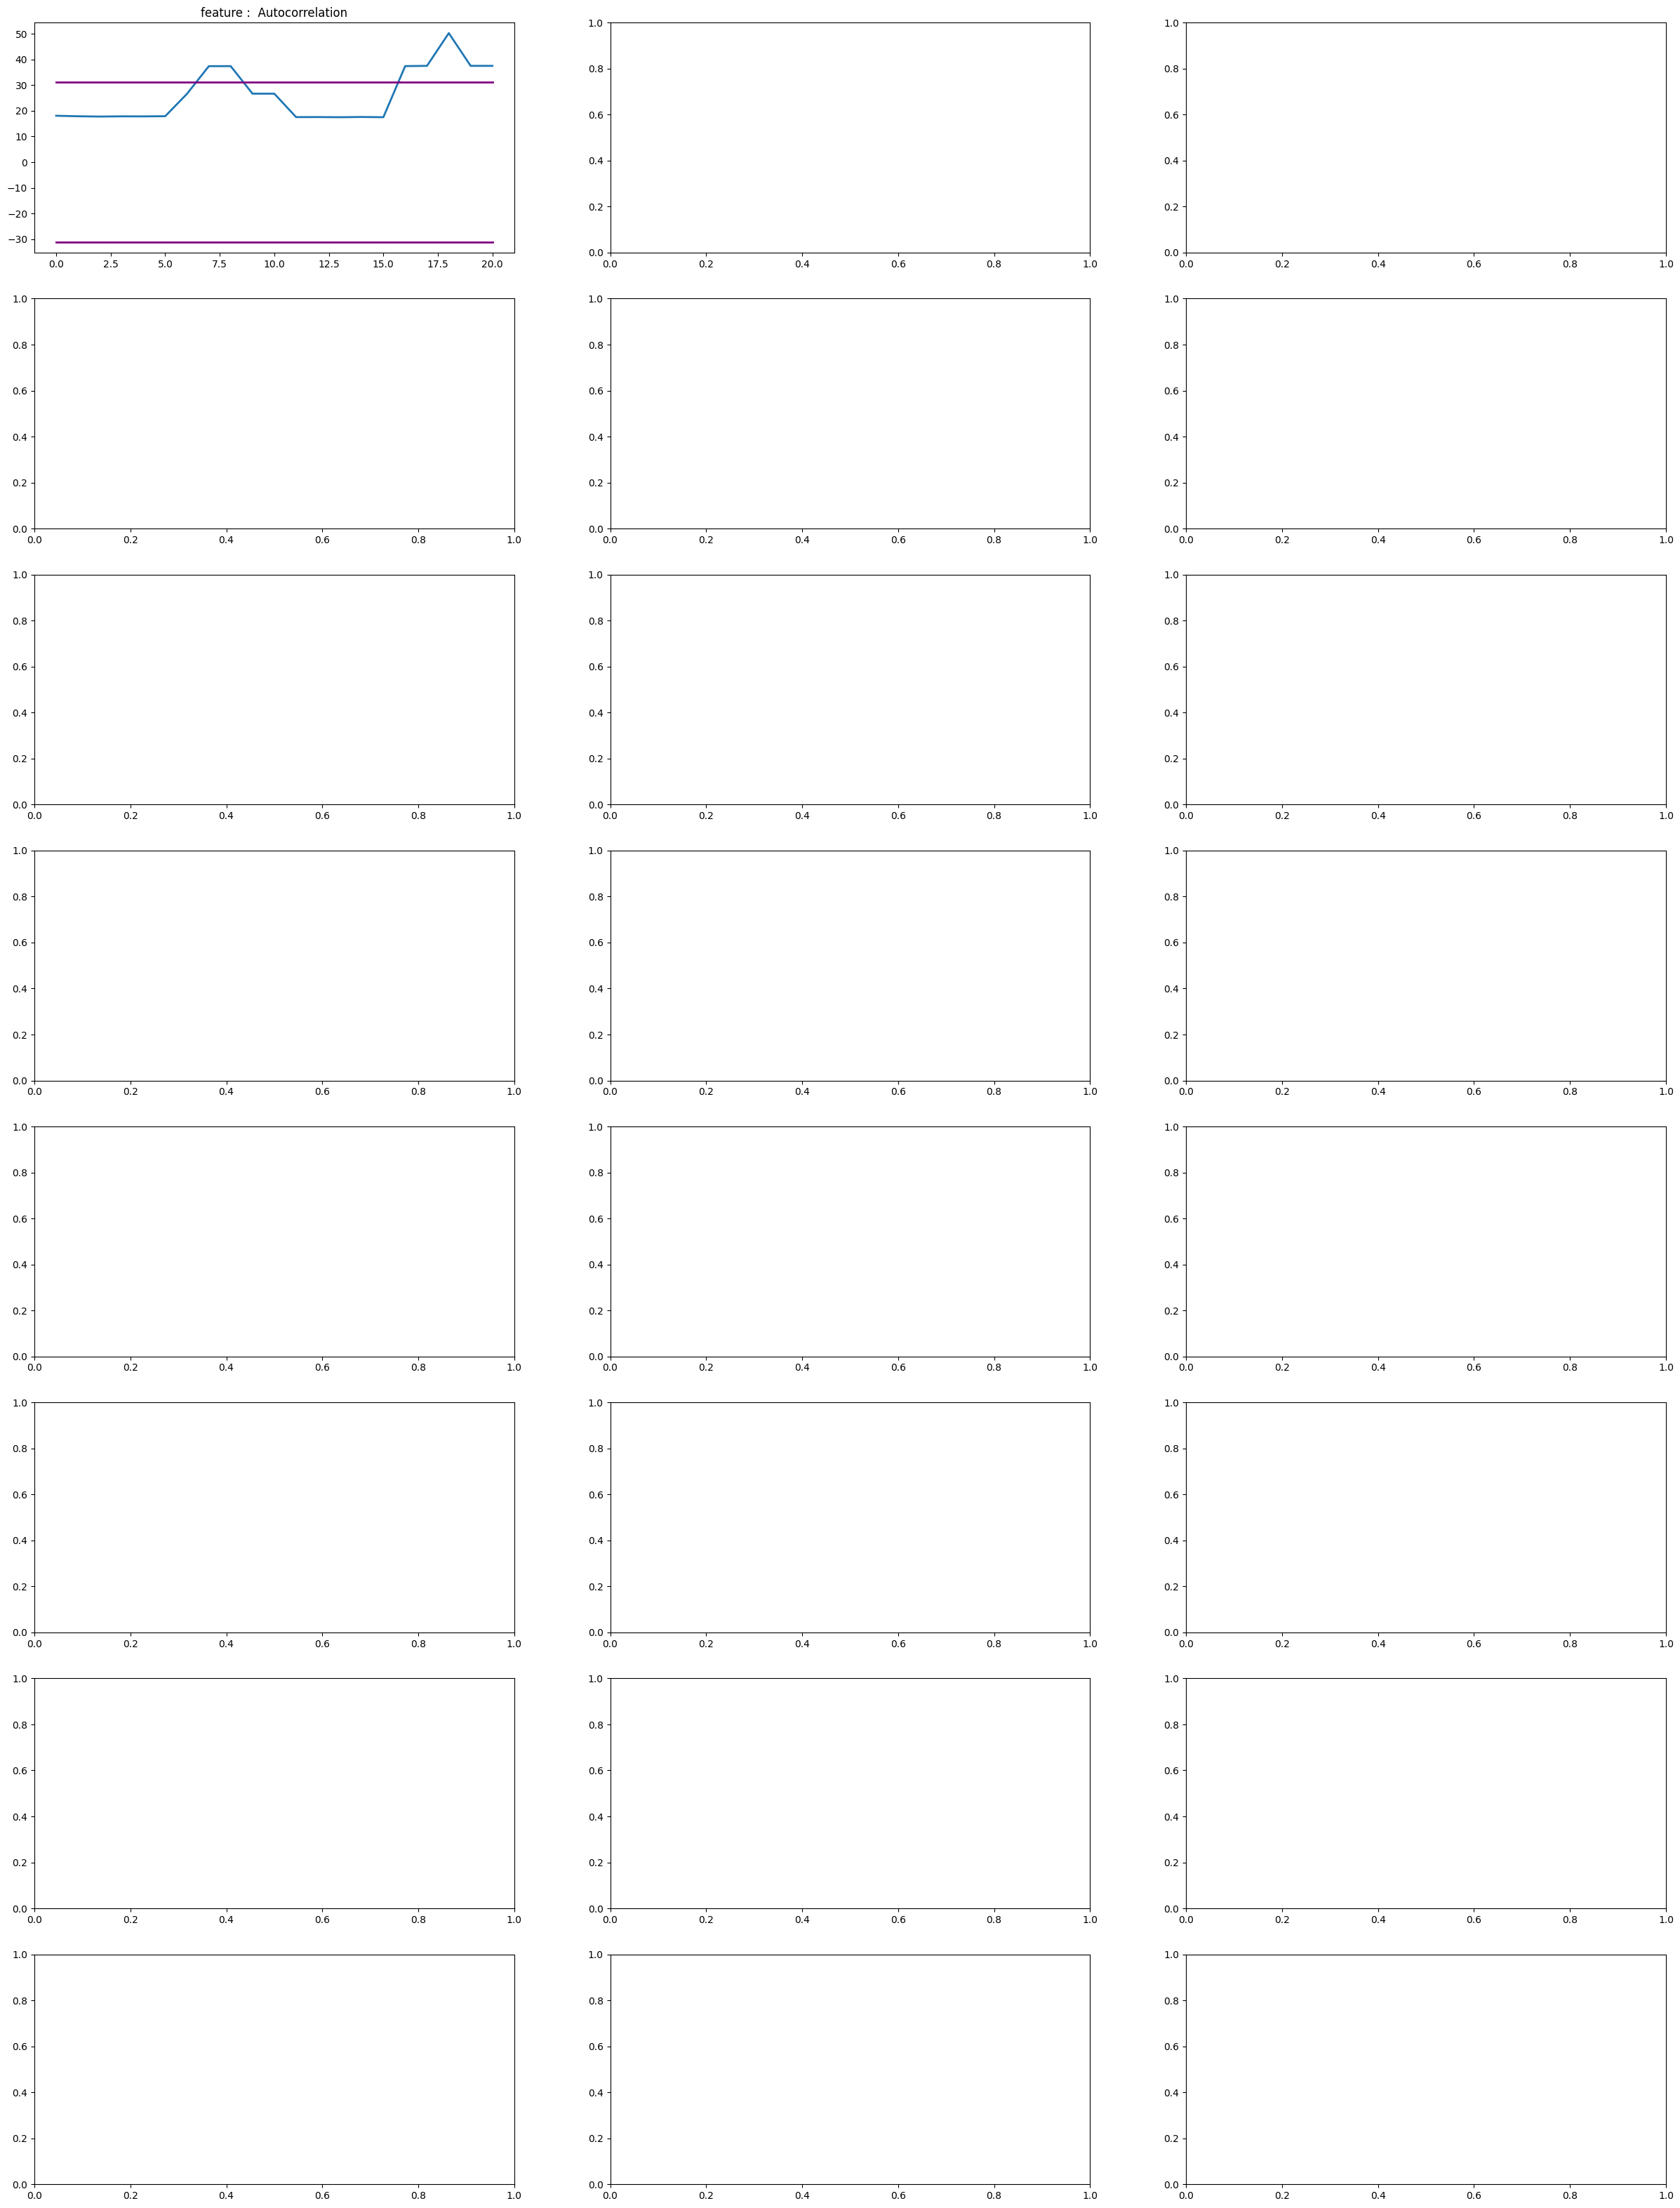

In [ ]:
n,p = features.shape

fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot(features[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] )

        axs[i, j].plot(range(n),extreme_Features_im1[0,3*i+j]*np.ones(n),c='purple', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[1,3*i+j]*np.ones(n),c ='purple', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[2,3*i+j]*np.ones(n),c='red', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[3,3*i+j]*np.ones(n),c ='red', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[4,3*i+j]*np.ones(n),c='magenta', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[5,3*i+j]*np.ones(n),c ='magenta', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[6,3*i+j]*np.ones(n),c='cyan', linewidth=2)
        axs[i, j].plot(range(n),extreme_Features_im1[7,3*i+j]*np.ones(n),c ='cyan', linewidth=2)

# Adjust spacing between subplots
#plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
print(np.unique(im_transformed))

[-93 -89 -87 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73 -72 -71 -70 -69
 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51
 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 16

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

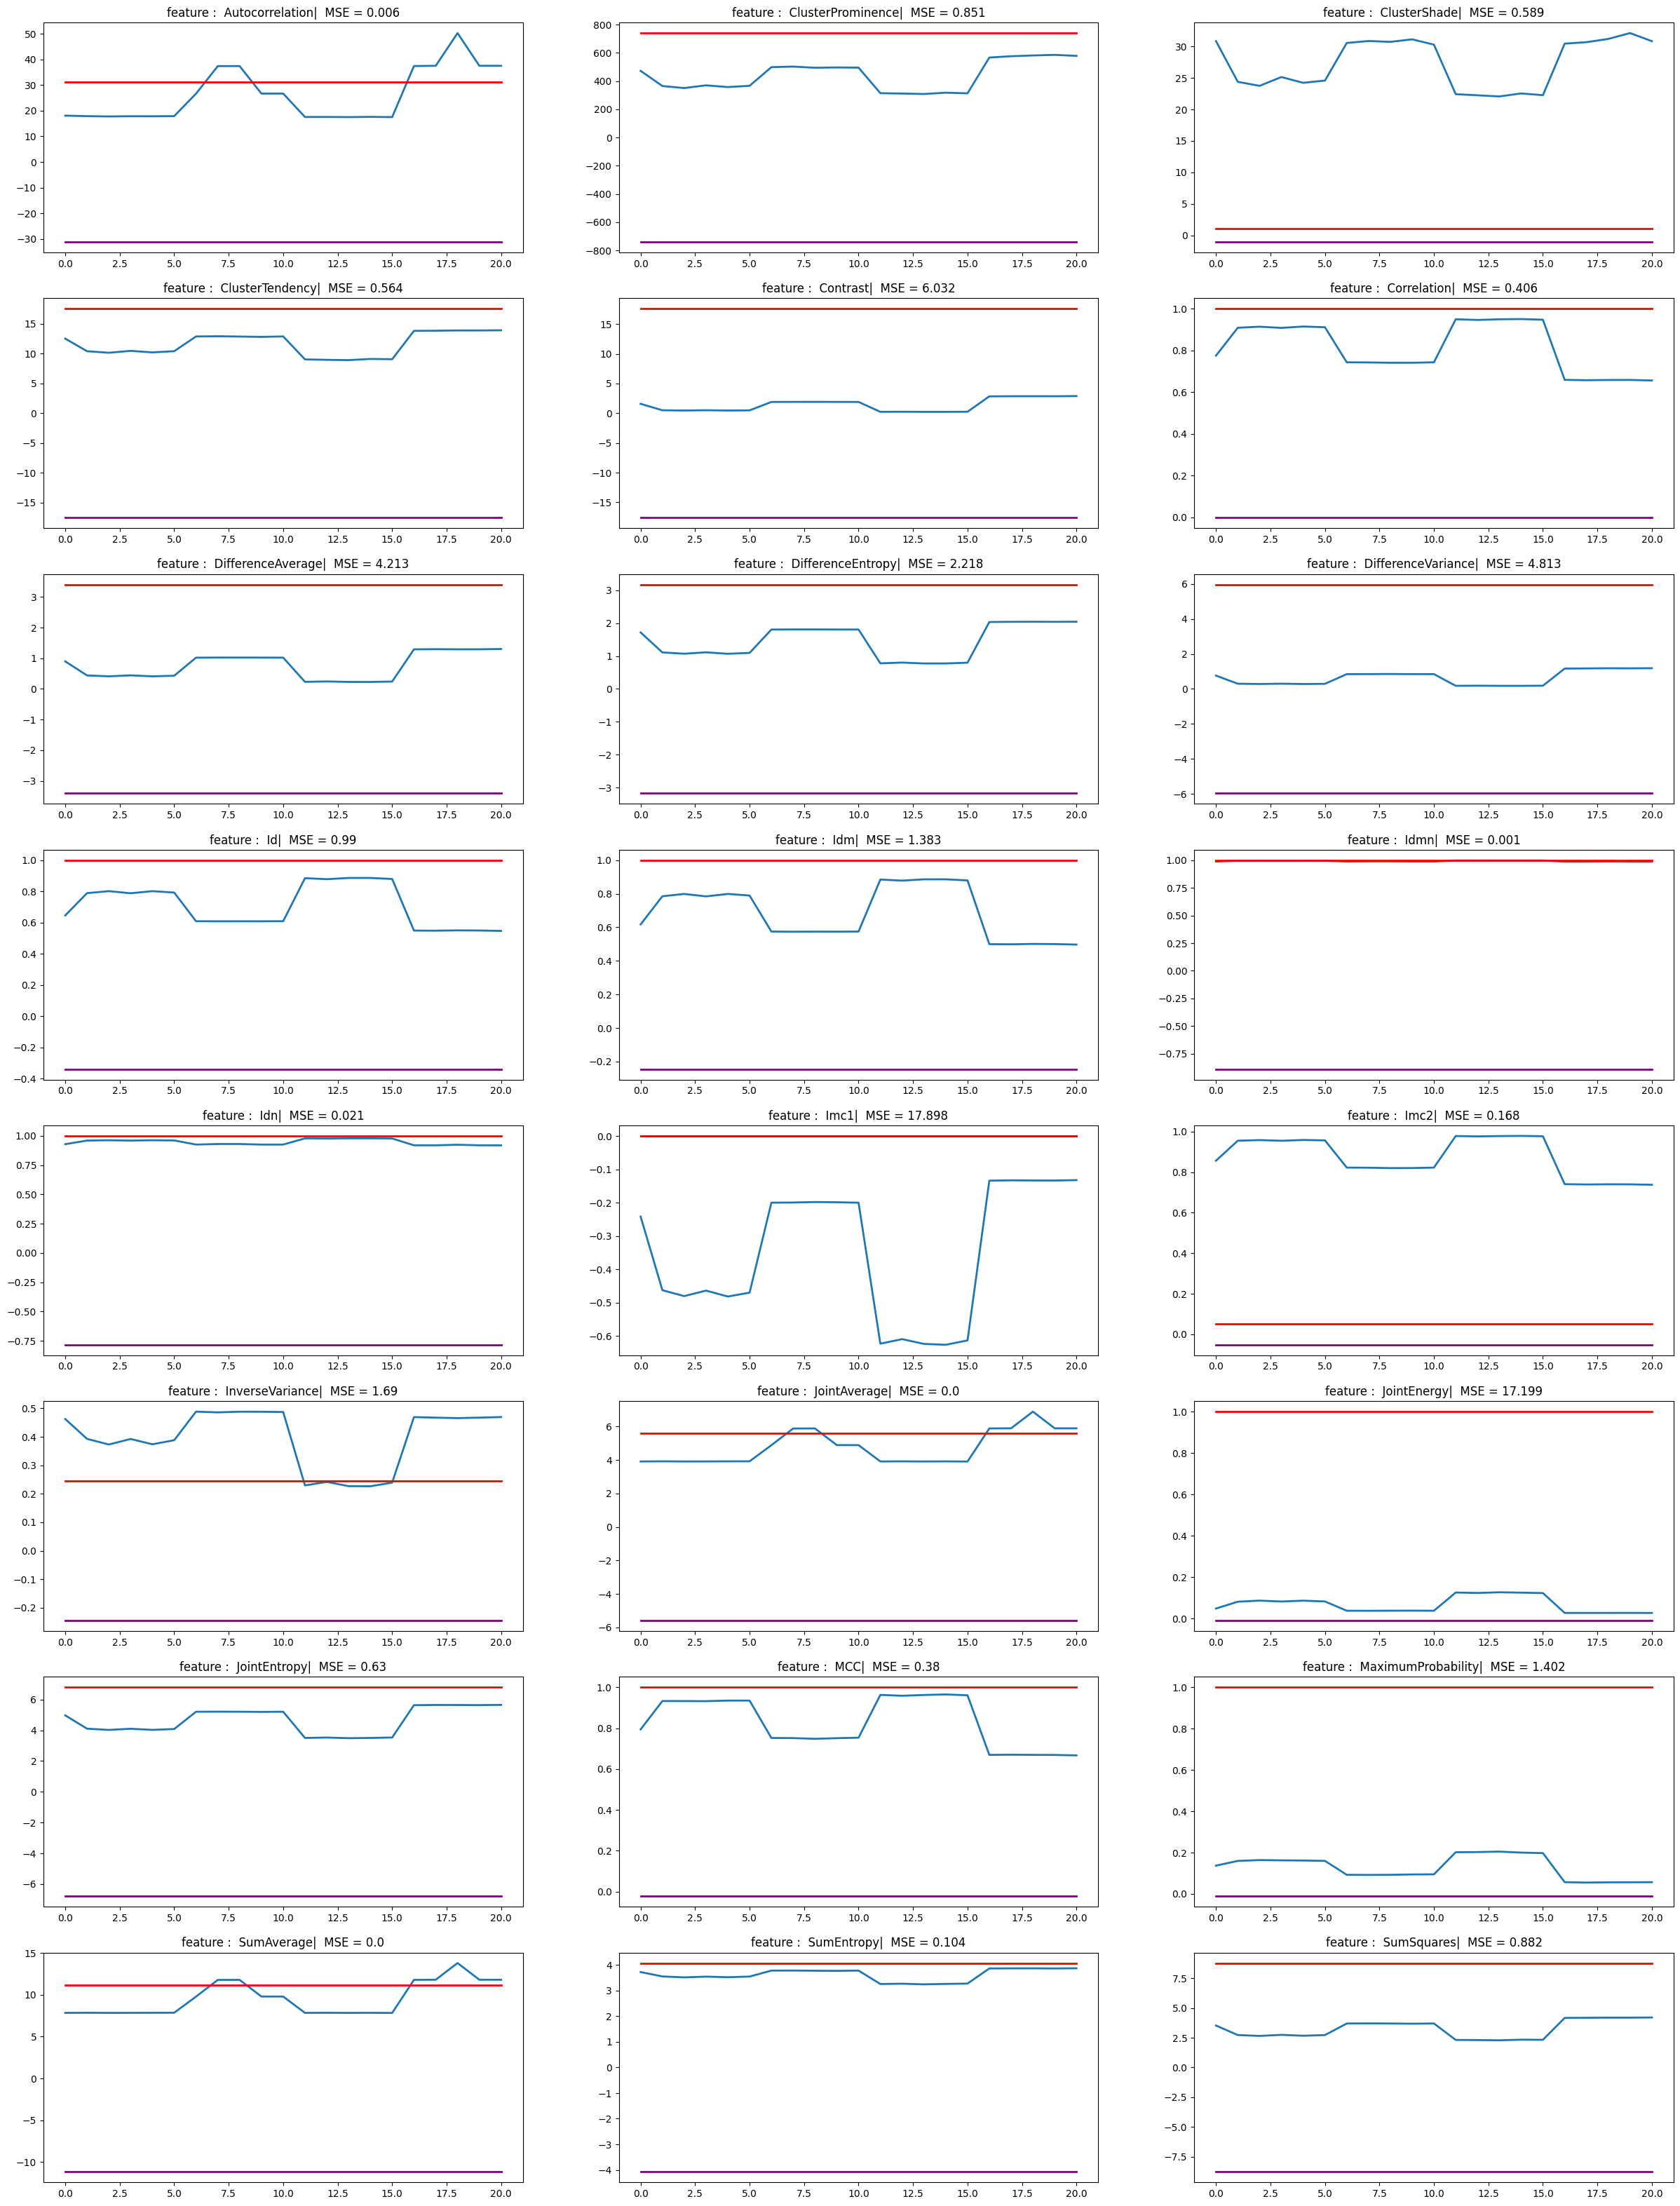

In [ ]:
extreme_Features_im1 = np.array(extreme_Features(im1_ITK, mask1_ITK))

im_transformed   = [flou(im1,kernel_size=3).astype(np.int32) for i in range(5)]
im_transformed  += [noise(im1, br = 10).astype(np.int32) for i in range(5)]
im_transformed  += [flou(im1, kernel_size=5).astype(np.int32) for i in range(5)]
im_transformed  += [noise(im1, br = 20).astype(np.int32) for i in range(5)]

glcmFeatures = glcm.RadiomicsGLCM(im1_ITK, mask1_ITK)
glcmFeatures.enableAllFeatures()
result = glcmFeatures.execute()

features = [ list(result.values()) ]

for i in range(len(im_transformed)):
  im_transformed_ITK_i = sitk.GetImageFromArray(im_transformed[i])

  glcmFeatures = glcm.RadiomicsGLCM(im_transformed_ITK_i, mask1_ITK)
  glcmFeatures.enableAllFeatures()
  result = glcmFeatures.execute()

  features.append( list(result.values()) )

features = np.array(features)

n,p = features.shape

fig, axs = plt.subplots(8, 3,figsize=(30, 40))



for i in range(8):
    for j in range(3):
        axs[i, j].plot(features[:,3*i+j], linewidth=2)
        axs[i, j].set_title('feature :  '  + args[3*i+j] +  '|  MSE = ' + str( round(blurr_MSE_1[3*i+j], 3) ))

        axs[i, j].plot(range(n),extreme_Features_im1[0,3*i+j]*np.ones(n),c='purple', linewidth=2)

        axs[i, j].plot(range(n),extreme_Features_im1[1,3*i+j]*np.ones(n),c ='red', linewidth=2)

# Adjust spacing between subplots
#plt.tight_layout()

# Show the figure
plt.show()



# TESTS 

In [ ]:

(histo,bins)=np.histogram((im1*mask1).reshape((-1,)),np.arange(0,256)) #le reshape est inutile pour np.histogram, mais on le laisse pour la compatibilite avec plt.hist
histo=histo/histo.sum()
histocum=histo.cumsum()


imequal = histocum[np.uint8(im1)]


(-0.5, 455.5, 455.5, -0.5)

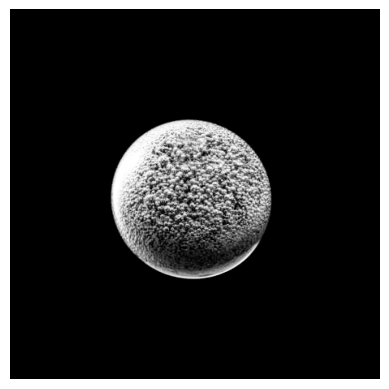

In [ ]:
plt.imshow(imequal, cmap='gray')
plt.axis('off')

In [ ]:
import cv2
import numpy as np

def linear_contrast_adaptation(image):
    # Charger l'image en niveaux de gris

    # Trouver les valeurs minimale et maximale des niveaux de gris dans l'image
    min_intensity = np.min(image)
    max_intensity = np.max(image)

    # Appliquer la transformation linéaire
    contrast_image = np.clip((image - min_intensity) * (255.0 / (max_intensity - min_intensity)), 0, 255).astype(np.uint8)

    # Afficher l'image d'origine et l'image transformée
    cv2.imshow('Original Image', image)
    cv2.imshow('Contrast Adapted Image', contrast_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Enregistrer l'image transformée
    cv2.imwrite('contrast_adapted_image.jpg', contrast_image)


In [ ]:
print(args)

['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'Id', 'Idm', 'Idmn', 'Idn', 'Imc1', 'Imc2', 'InverseVariance', 'JointAverage', 'JointEnergy', 'JointEntropy', 'MCC', 'MaximumProbability', 'SumAverage', 'SumEntropy', 'SumSquares']
